# Model 1:

In [1]:
#! pip3 install auto-sklearn

In [2]:
import os
os.chdir('..')

In [3]:
import pandas as pd
import os
import numpy as np
RNDSEED = np.random.seed(39)
PRECISION = 4 # 3 of digits to keep after the decimal point
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import f1_score, cohen_kappa_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
RUNNING_ON_COLAB = False # we assume running on CoLab! Change to False if running locally.

*italicized text*

In [4]:
## mount gdrive
#from google.colab import drive#
#drive.mount("/content/gdrive")

In [5]:
# If running locally, define current working path
path = os.getcwd()

# If Google colab
if RUNNING_ON_COLAB:
    path = "/content/gdrive/My Drive/Colab Notebooks/RandomForest_FeatureData"

print(path)

# define current data path. This is after we did classification. We have done some
# cleaning already.
data_path = path + '/fl_testbed/version2/data/initial'
print(data_path)
#/home/jose/FL_AM_Defect-Detection
#/home/jose/FL_AM_Defect-Detection/fl_testbed/version2/data/initial

/home/jose/FL_AM_Defect-Detection
/home/jose/FL_AM_Defect-Detection/fl_testbed/version2/data/initial


## Play code

<font color=cyan>The key is to transform the time column! </font>


In [6]:
!cd '/home/jose/FL_AM_Defect-Detection/notebooks/fl_testbed/version2/data/initial' && ls

/bin/bash: line 0: cd: /home/jose/FL_AM_Defect-Detection/notebooks/fl_testbed/version2/data/initial: No such file or directory


In [7]:
## start - play code
print(data_path)
csv_file = data_path + '/combined_offset_misalignment_M3.csv'
df_temp = pd.read_csv(csv_file, chunksize=50000) 
df = pd.concat(df_temp, ignore_index=True)

/home/jose/FL_AM_Defect-Detection/fl_testbed/version2/data/initial


In [8]:
print(df.columns)

Index(['Unnamed: 0', 'index', 'wf_start_time', 'S1_CrestFactor_g~g',
       'S1_DerivedPeak_g', 'S1_Peak~Peak_g', 'S1_RMS_g', 'S1_TruePeak_g',
       'S1_HighFrequency_grms', 'S1_Kurtosis_g~g', 'S2_CrestFactor_g~g',
       'S2_DerivedPeak_g', 'S2_Peak~Peak_g', 'S2_RMS_g', 'S2_TruePeak_g',
       'S2_HighFrequency_grms', 'S2_Kurtosis_g~g', 'S1_temp', 'status', 'rul'],
      dtype='object')


In [9]:
df.head(5)

,Unnamed: 0,index,wf_start_time,S1_CrestFactor_g~g,S1_DerivedPeak_g,S1_Peak~Peak_g,S1_RMS_g,S1_TruePeak_g,S1_HighFrequency_grms,S1_Kurtosis_g~g,S2_CrestFactor_g~g,S2_DerivedPeak_g,S2_Peak~Peak_g,S2_RMS_g,S2_TruePeak_g,S2_HighFrequency_grms,S2_Kurtosis_g~g,S1_temp,status,rul
0,0,591557,2022-08-09 14:03:22.000007,12.3214,0.5170,8.3688,0.3655,4.5040,0.1355,29.4402,11.3516,0.8401,12.4549,0.5941,6.7436,0.1040,37.6491,72.4676,No_Offset,2009308.0
1,1,591558,2022-08-09 14:03:23.000007,5.5933,2.5483,20.0644,1.8019,10.0786,1.9368,8.9174,5.6735,1.8216,13.1957,1.2881,7.3079,0.2197,5.0971,72.4427,No_Offset,2009307.0
2,2,591559,2022-08-09 14:03:24.000007,4.0140,2.5484,14.3660,1.8020,7.2333,1.6188,5.0306,7.7328,1.2040,11.7569,0.8513,6.5833,0.3566,12.4059,72.4770,No_Offset,2009306.0
3,3,591560,2022-08-09 14:03:25.000007,2.6487,0.6943,2.5795,0.4910,1.3004,0.4809,2.2368,3.7461,0.2835,1.4845,0.2004,0.7508,0.1578,2.8937,72.4549,No_Offset,2009305.0
4,4,591561,2022-08-09 14:03:26.000007,2.5022,0.6752,2.3616,0.4774,1.1946,0.4748,2.2111,3.7041,0.2932,1.4761,0.2073,0.7679,0.1620,2.7997,72.4988,No_Offset,2009304.0


In [10]:
#238722
#DO NOT FORGET SORT VALUES
df1=df.loc[0:238721].sort_values(by='wf_start_time').reset_index()
df2=df.loc[0+238722:0+238722+238722-1].sort_values(by='wf_start_time').reset_index()
df3=df.loc[0+238722+238722:].sort_values(by='wf_start_time').reset_index()

In [11]:
lists=[]
for df in [df1,df2,df3]:
    try:
        # Let's find the youngest & oldest timestamp

        df['wf_start_time'] = pd.to_datetime(df['wf_start_time']) # make sure it is datetime

        youngest = min(df.wf_start_time)
        oldest = max(df.wf_start_time)

        print(youngest)
        print(oldest)
        span = oldest - youngest
        print(span)
        print(span.total_seconds())

        ## Using Oldest - current to determine the RUL
        df['rul'] = df['wf_start_time'].apply(lambda x: (oldest - x).total_seconds())
        lists.append(df)
    except Exception as e:
        print("CHECK INPUT DATA ", str(e))
        pass

# lists=[]
# for df in [df1,df2,df3]:
#     # Let's find the youngest & oldest timestamp

#     df['wf_start_time'] = pd.to_datetime(df['wf_start_time']) # make sure it is datetime

#     youngest = min(df.wf_start_time)
#     oldest = max(df.wf_start_time)
#     print(youngest)
#     print(oldest)
#     span = oldest - youngest
#     print(span)
#     print(span.total_seconds())

#     ## Using Oldest - current to determine the RUL
#     df['rul'] = df['wf_start_time'].apply(lambda x: (oldest - x).total_seconds())
#     lists.append(df)


2022-08-09 14:03:22.000007
2022-09-01 20:11:50.000007
23 days 06:08:28
2009308.0
CHECK INPUT DATA  min() arg is an empty sequence
CHECK INPUT DATA  min() arg is an empty sequence


# IMPORTANT THERE ARE 3 FILES _M1,_M2,_M3 EACH REPRESENTS A MOTOR SETUP WITH 2 PROBES AND 1 TEMPERATURE SENSOR* 

# Similarly the whole dataset can be used!

# ONLY ONE SET OF SIGNALS!

In [12]:
lists

[        level_0  Unnamed: 0   index              wf_start_time  \
 0             0           0  591557 2022-08-09 14:03:22.000007   
 1             1           1  591558 2022-08-09 14:03:23.000007   
 2             2           2  591559 2022-08-09 14:03:24.000007   
 3             3           3  591560 2022-08-09 14:03:25.000007   
 4             4           4  591561 2022-08-09 14:03:26.000007   
 ...         ...         ...     ...                        ...   
 238717   238717      238717  643079 2022-09-01 20:11:29.000007   
 238718   238718      238718  643080 2022-09-01 20:11:30.000007   
 238719   238719      238719  643081 2022-09-01 20:11:31.000007   
 238720   238720      238720  643082 2022-09-01 20:11:32.000007   
 238721   238721      238721  643083 2022-09-01 20:11:50.000007   
 
         S1_CrestFactor_g~g  S1_DerivedPeak_g  S1_Peak~Peak_g  S1_RMS_g  \
 0                  12.3214            0.5170          8.3688    0.3655   
 1                   5.5933            2.548

In [13]:
df=pd.concat(lists[-1:],ignore_index=True)

In [14]:
df.shape

(238722, 21)

In [15]:
# drop Unnamed columns
df = df[df.columns.drop(list(df.filter(regex='Unnamed')))]


# SMALLER SET! NOT APPLIED AT THE MOMENT

In [16]:
# df=df[['index','wf_start_time','S1_HighFrequency_grms','S1_Kurtosis_g~g','S1_RMS_g','status','rul']]

In [17]:
df.loc[0:238721]


,level_0,index,wf_start_time,S1_CrestFactor_g~g,S1_DerivedPeak_g,S1_Peak~Peak_g,S1_RMS_g,S1_TruePeak_g,S1_HighFrequency_grms,S1_Kurtosis_g~g,S2_CrestFactor_g~g,S2_DerivedPeak_g,S2_Peak~Peak_g,S2_RMS_g,S2_TruePeak_g,S2_HighFrequency_grms,S2_Kurtosis_g~g,S1_temp,status,rul
0,0,591557,2022-08-09 14:03:22.000007,12.3214,0.5170,8.3688,0.3655,4.5040,0.1355,29.4402,11.3516,0.8401,12.4549,0.5941,6.7436,0.1040,37.6491,72.4676,No_Offset,2009308.0
1,1,591558,2022-08-09 14:03:23.000007,5.5933,2.5483,20.0644,1.8019,10.0786,1.9368,8.9174,5.6735,1.8216,13.1957,1.2881,7.3079,0.2197,5.0971,72.4427,No_Offset,2009307.0
2,2,591559,2022-08-09 14:03:24.000007,4.0140,2.5484,14.3660,1.8020,7.2333,1.6188,5.0306,7.7328,1.2040,11.7569,0.8513,6.5833,0.3566,12.4059,72.4770,No_Offset,2009306.0
3,3,591560,2022-08-09 14:03:25.000007,2.6487,0.6943,2.5795,0.4910,1.3004,0.4809,2.2368,3.7461,0.2835,1.4845,0.2004,0.7508,0.1578,2.8937,72.4549,No_Offset,2009305.0
4,4,591561,2022-08-09 14:03:26.000007,2.5022,0.6752,2.3616,0.4774,1.1946,0.4748,2.2111,3.7041,0.2932,1.4761,0.2073,0.7679,0.1620,2.7997,72.4988,No_Offset,2009304.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238717,238717,643079,2022-09-01 20:11:29.000007,2.5083,0.6880,2.3624,0.4865,1.2203,0.4834,2.1624,3.5082,0.2728,1.2713,0.1929,0.6767,0.1447,2.7364,73.5386,12.7mm_Offset,21.0
238718,238718,643080,2022-09-01 20:11:30.000007,2.3925,0.6879,2.2706,0.4864,1.1638,0.4837,2.1555,3.2138,0.2856,1.2836,0.2020,0.6491,0.1457,2.7667,73.5767,12.7mm_Offset,20.0
238719,238719,643081,2022-09-01 20:11:31.000007,5.7067,0.2556,2.0422,0.1808,1.0315,0.0308,13.5090,5.3715,0.1918,1.3841,0.1356,0.7285,0.0184,3.9787,73.5347,12.7mm_Offset,19.0
238720,238720,643082,2022-09-01 20:11:32.000007,4.2261,0.0406,0.2402,0.0287,0.1215,0.0115,3.1910,4.3151,0.1361,0.7445,0.0963,0.4154,0.0036,3.2765,73.5728,12.7mm_Offset,18.0


In [18]:
df.loc[0+238722:0+238722+238722-1]


,level_0,index,wf_start_time,S1_CrestFactor_g~g,S1_DerivedPeak_g,S1_Peak~Peak_g,S1_RMS_g,S1_TruePeak_g,S1_HighFrequency_grms,S1_Kurtosis_g~g,S2_CrestFactor_g~g,S2_DerivedPeak_g,S2_Peak~Peak_g,S2_RMS_g,S2_TruePeak_g,S2_HighFrequency_grms,S2_Kurtosis_g~g,S1_temp,status,rul


In [19]:
df.loc[0+238722+238722:]

,level_0,index,wf_start_time,S1_CrestFactor_g~g,S1_DerivedPeak_g,S1_Peak~Peak_g,S1_RMS_g,S1_TruePeak_g,S1_HighFrequency_grms,S1_Kurtosis_g~g,S2_CrestFactor_g~g,S2_DerivedPeak_g,S2_Peak~Peak_g,S2_RMS_g,S2_TruePeak_g,S2_HighFrequency_grms,S2_Kurtosis_g~g,S1_temp,status,rul


In [20]:
df.columns

Index(['level_0', 'index', 'wf_start_time', 'S1_CrestFactor_g~g',
       'S1_DerivedPeak_g', 'S1_Peak~Peak_g', 'S1_RMS_g', 'S1_TruePeak_g',
       'S1_HighFrequency_grms', 'S1_Kurtosis_g~g', 'S2_CrestFactor_g~g',
       'S2_DerivedPeak_g', 'S2_Peak~Peak_g', 'S2_RMS_g', 'S2_TruePeak_g',
       'S2_HighFrequency_grms', 'S2_Kurtosis_g~g', 'S1_temp', 'status', 'rul'],
      dtype='object')

## Util - add RUL column

In [21]:
df.loc[0:238721]


,level_0,index,wf_start_time,S1_CrestFactor_g~g,S1_DerivedPeak_g,S1_Peak~Peak_g,S1_RMS_g,S1_TruePeak_g,S1_HighFrequency_grms,S1_Kurtosis_g~g,S2_CrestFactor_g~g,S2_DerivedPeak_g,S2_Peak~Peak_g,S2_RMS_g,S2_TruePeak_g,S2_HighFrequency_grms,S2_Kurtosis_g~g,S1_temp,status,rul
0,0,591557,2022-08-09 14:03:22.000007,12.3214,0.5170,8.3688,0.3655,4.5040,0.1355,29.4402,11.3516,0.8401,12.4549,0.5941,6.7436,0.1040,37.6491,72.4676,No_Offset,2009308.0
1,1,591558,2022-08-09 14:03:23.000007,5.5933,2.5483,20.0644,1.8019,10.0786,1.9368,8.9174,5.6735,1.8216,13.1957,1.2881,7.3079,0.2197,5.0971,72.4427,No_Offset,2009307.0
2,2,591559,2022-08-09 14:03:24.000007,4.0140,2.5484,14.3660,1.8020,7.2333,1.6188,5.0306,7.7328,1.2040,11.7569,0.8513,6.5833,0.3566,12.4059,72.4770,No_Offset,2009306.0
3,3,591560,2022-08-09 14:03:25.000007,2.6487,0.6943,2.5795,0.4910,1.3004,0.4809,2.2368,3.7461,0.2835,1.4845,0.2004,0.7508,0.1578,2.8937,72.4549,No_Offset,2009305.0
4,4,591561,2022-08-09 14:03:26.000007,2.5022,0.6752,2.3616,0.4774,1.1946,0.4748,2.2111,3.7041,0.2932,1.4761,0.2073,0.7679,0.1620,2.7997,72.4988,No_Offset,2009304.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238717,238717,643079,2022-09-01 20:11:29.000007,2.5083,0.6880,2.3624,0.4865,1.2203,0.4834,2.1624,3.5082,0.2728,1.2713,0.1929,0.6767,0.1447,2.7364,73.5386,12.7mm_Offset,21.0
238718,238718,643080,2022-09-01 20:11:30.000007,2.3925,0.6879,2.2706,0.4864,1.1638,0.4837,2.1555,3.2138,0.2856,1.2836,0.2020,0.6491,0.1457,2.7667,73.5767,12.7mm_Offset,20.0
238719,238719,643081,2022-09-01 20:11:31.000007,5.7067,0.2556,2.0422,0.1808,1.0315,0.0308,13.5090,5.3715,0.1918,1.3841,0.1356,0.7285,0.0184,3.9787,73.5347,12.7mm_Offset,19.0
238720,238720,643082,2022-09-01 20:11:32.000007,4.2261,0.0406,0.2402,0.0287,0.1215,0.0115,3.1910,4.3151,0.1361,0.7445,0.0963,0.4154,0.0036,3.2765,73.5728,12.7mm_Offset,18.0


In [22]:
df.loc[0+238722:0+238722+238722-1]


,level_0,index,wf_start_time,S1_CrestFactor_g~g,S1_DerivedPeak_g,S1_Peak~Peak_g,S1_RMS_g,S1_TruePeak_g,S1_HighFrequency_grms,S1_Kurtosis_g~g,S2_CrestFactor_g~g,S2_DerivedPeak_g,S2_Peak~Peak_g,S2_RMS_g,S2_TruePeak_g,S2_HighFrequency_grms,S2_Kurtosis_g~g,S1_temp,status,rul


In [23]:
df.loc[0+238722+238722:] #NOW THIS IS VALIDATION DATA

,level_0,index,wf_start_time,S1_CrestFactor_g~g,S1_DerivedPeak_g,S1_Peak~Peak_g,S1_RMS_g,S1_TruePeak_g,S1_HighFrequency_grms,S1_Kurtosis_g~g,S2_CrestFactor_g~g,S2_DerivedPeak_g,S2_Peak~Peak_g,S2_RMS_g,S2_TruePeak_g,S2_HighFrequency_grms,S2_Kurtosis_g~g,S1_temp,status,rul


## RF Regression

In [24]:
## Common imports
import pandas as pd
import numpy as np
import csv
import os

from sklearn import tree
from sklearn import metrics
from sklearn.metrics import f1_score, cohen_kappa_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score, mean_squared_error
# from pandas_ml import ConfusionMatrix

import matplotlib
import matplotlib.pyplot as plt
plt.style.available
%matplotlib inline

# to make this notebook's output stable across runs
RNDSEED = np.random.seed(39)

### Exploring the data a bit & prep the df

In [25]:
#df = big_df # reset 

# drop unwanted cols
df = df[df.columns.drop(list(df.filter(regex='Unnamed')))] # drop Unnamed
df = df[df.columns.drop(list(df.filter(regex='wf_start_time')))] # drop time column
#df = df[df.columns.drop(list(df.filter(regex='status')))] # drop status column
df = df[df.columns.drop(list(df.filter(regex='index')))] # drop status column

df = df[df.columns.drop(list(df.filter(regex='level_0')))] # drop status column


# Map OFFSET TYPE OF ERROR

In [26]:
status_map = {
    "No_Offset": 0,
    "1mm_Offset": 1,
    "3mm_Offset": 2,
    "6.25mm_Offset": 3,
    "12.7mm_Offset": 4,
}

df["status"] = df["status"].map(status_map)

In [27]:
df.shape

(238722, 17)

In [28]:
df.columns

Index(['S1_CrestFactor_g~g', 'S1_DerivedPeak_g', 'S1_Peak~Peak_g', 'S1_RMS_g',
       'S1_TruePeak_g', 'S1_HighFrequency_grms', 'S1_Kurtosis_g~g',
       'S2_CrestFactor_g~g', 'S2_DerivedPeak_g', 'S2_Peak~Peak_g', 'S2_RMS_g',
       'S2_TruePeak_g', 'S2_HighFrequency_grms', 'S2_Kurtosis_g~g', 'S1_temp',
       'status', 'rul'],
      dtype='object')

# Removing Outliers

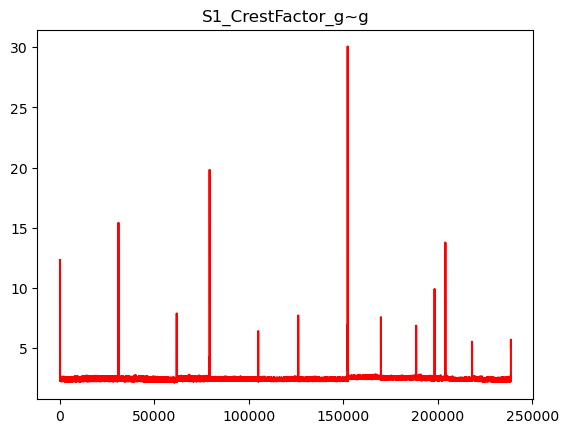

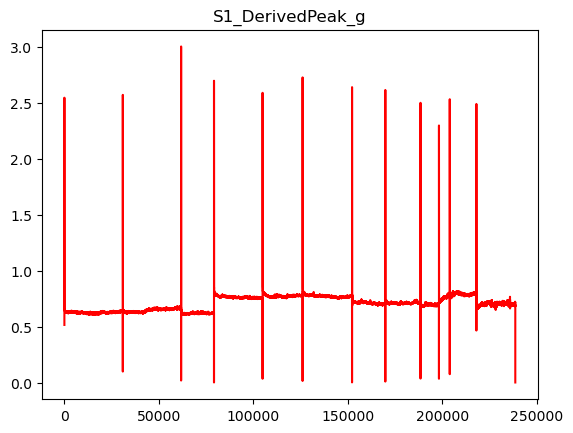

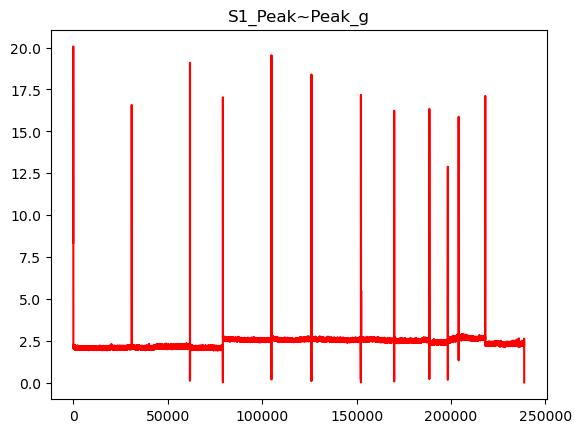

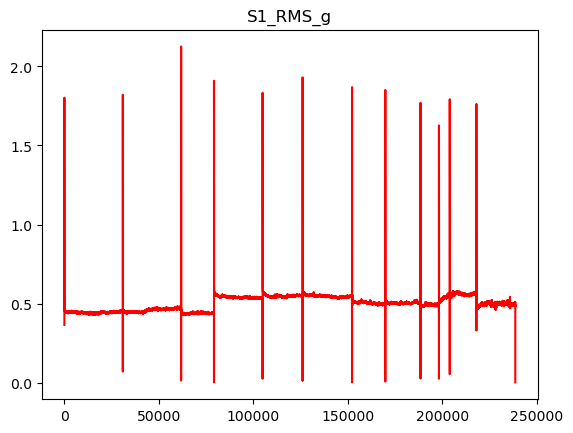

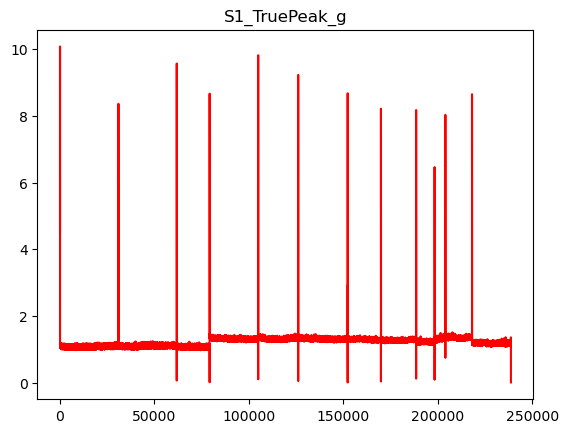

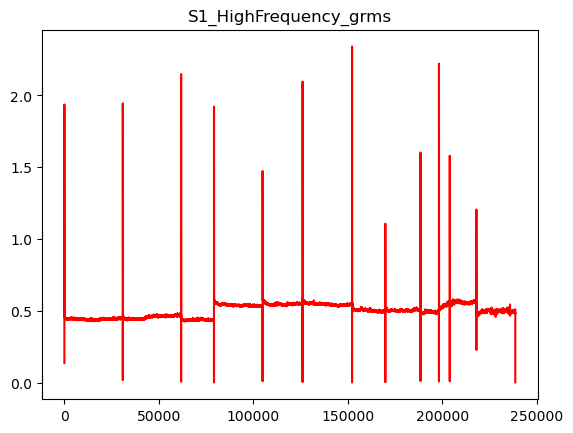

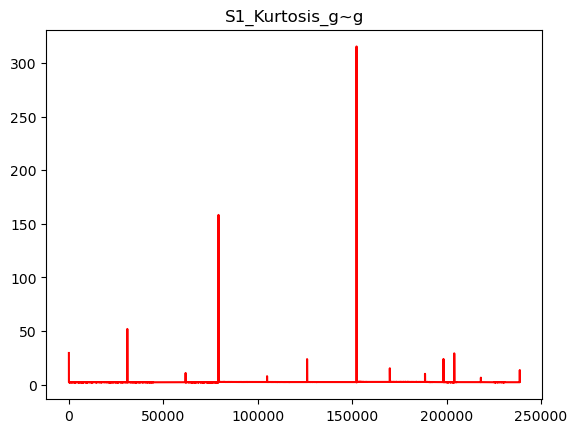

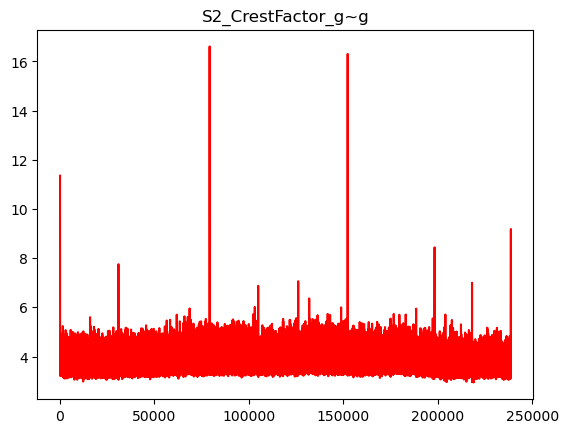

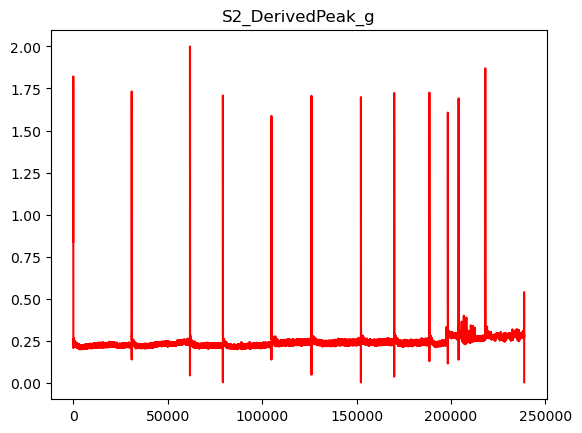

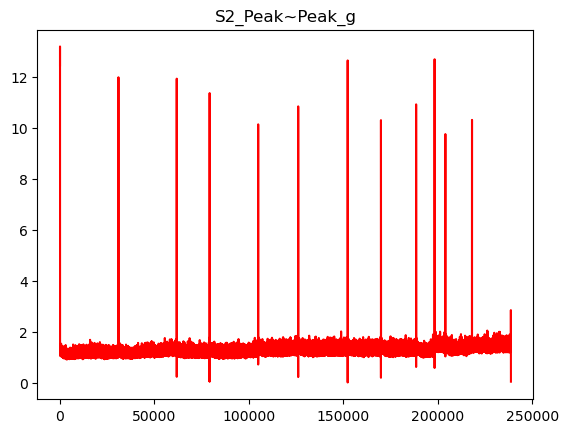

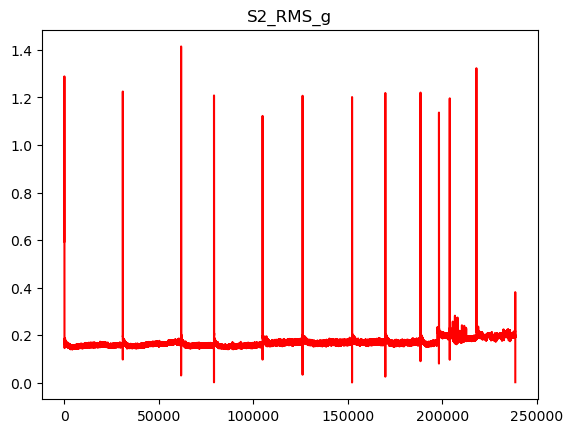

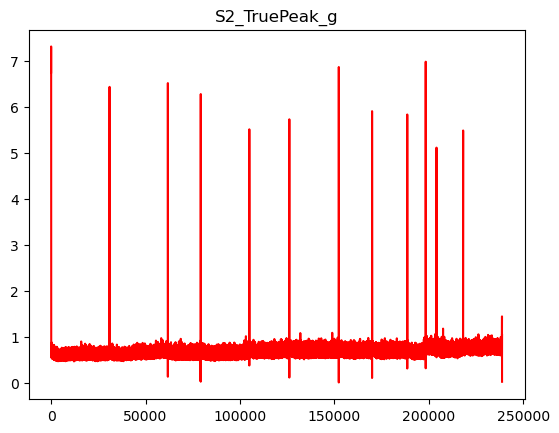

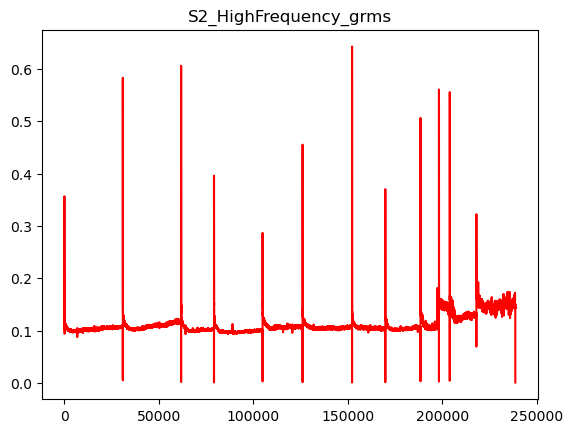

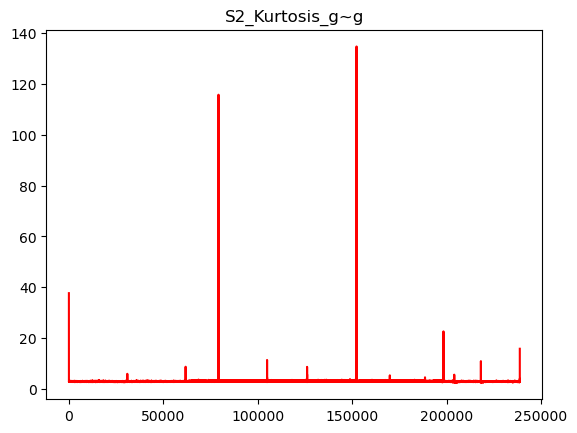

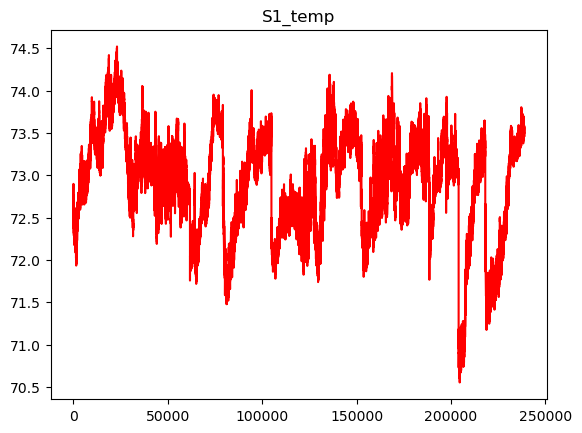

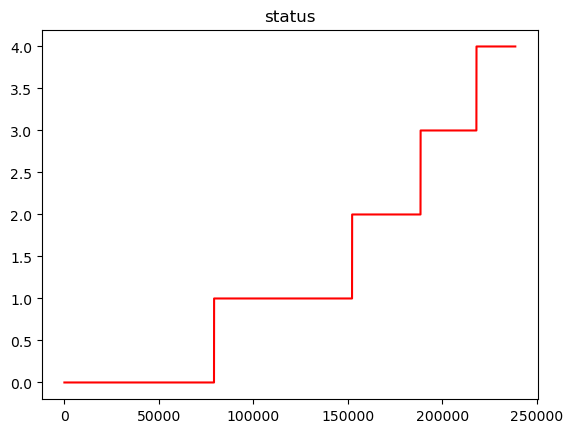

In [29]:

for i in df.columns[:-1]:
    
    y=df[[i]].values
    


    x = range(0,len(y))

    plt.title("Line graph")
    plt.plot(x, y, color="red")
    plt.title(str(i))

    plt.show()

In [30]:
from scipy import stats


cols = list(df.columns[:-3])

print(cols)


['S1_CrestFactor_g~g', 'S1_DerivedPeak_g', 'S1_Peak~Peak_g', 'S1_RMS_g', 'S1_TruePeak_g', 'S1_HighFrequency_grms', 'S1_Kurtosis_g~g', 'S2_CrestFactor_g~g', 'S2_DerivedPeak_g', 'S2_Peak~Peak_g', 'S2_RMS_g', 'S2_TruePeak_g', 'S2_HighFrequency_grms', 'S2_Kurtosis_g~g']


# OUTLIERS REMOVAL NOT LONGER USED

In [31]:

# df['S1_CrestFactor_g~g'] = df['S1_CrestFactor_g~g'].mask(np.abs(stats.zscore(df['S1_CrestFactor_g~g'])) >= 20)
# df['S1_DerivedPeak_g'] = df['S1_DerivedPeak_g'].mask(np.abs(stats.zscore(df['S1_DerivedPeak_g'])) >= 2)
# df['S1_Peak~Peak_g'] = df['S1_Peak~Peak_g'].mask(np.abs(stats.zscore(df['S1_Peak~Peak_g'])) >= 15)
# df['S1_RMS_g'] = df['S1_RMS_g'].mask(np.abs(stats.zscore(df['S1_RMS_g'])) >= 1)
# df['S1_TruePeak_g'] = df['S1_TruePeak_g'].mask(np.abs(stats.zscore(df['S1_TruePeak_g'])) >= 4)
# df['S1_HighFrequency_grms'] = df['S1_HighFrequency_grms'].mask(np.abs(stats.zscore(df['S1_HighFrequency_grms'])) >= 1.5)
# df['S1_Kurtosis_g~g'] = df['S1_Kurtosis_g~g'].mask(np.abs(stats.zscore(df['S1_Kurtosis_g~g'])) >= 50)
# df['S2_CrestFactor_g~g'] = df['S2_CrestFactor_g~g'].mask(np.abs(stats.zscore(df['S2_CrestFactor_g~g'])) >= 8)
# df['S2_DerivedPeak_g'] = df['S2_DerivedPeak_g'].mask(np.abs(stats.zscore(df['S2_DerivedPeak_g'])) >= 1)
# df['S2_Peak~Peak_g'] = df['S2_Peak~Peak_g'].mask(np.abs(stats.zscore(df['S2_Peak~Peak_g'])) >= 6)
# df['S2_RMS_g'] = df['S2_RMS_g'].mask(np.abs(stats.zscore(df['S2_RMS_g'])) >= 0.6)
# df['S2_TruePeak_g'] = df['S2_TruePeak_g'].mask(np.abs(stats.zscore(df['S2_TruePeak_g'])) >= 3)
# df['S2_HighFrequency_grms'] = df['S2_HighFrequency_grms'].mask(np.abs(stats.zscore(df['S2_HighFrequency_grms'])) >= 0.50)
# df['S2_Kurtosis_g~g'] = df['S2_Kurtosis_g~g'].mask(np.abs(stats.zscore(df['S2_Kurtosis_g~g'])) >= 20)



In [32]:
df

,S1_CrestFactor_g~g,S1_DerivedPeak_g,S1_Peak~Peak_g,S1_RMS_g,S1_TruePeak_g,S1_HighFrequency_grms,S1_Kurtosis_g~g,S2_CrestFactor_g~g,S2_DerivedPeak_g,S2_Peak~Peak_g,S2_RMS_g,S2_TruePeak_g,S2_HighFrequency_grms,S2_Kurtosis_g~g,S1_temp,status,rul
0,12.3214,0.5170,8.3688,0.3655,4.5040,0.1355,29.4402,11.3516,0.8401,12.4549,0.5941,6.7436,0.1040,37.6491,72.4676,0,2009308.0
1,5.5933,2.5483,20.0644,1.8019,10.0786,1.9368,8.9174,5.6735,1.8216,13.1957,1.2881,7.3079,0.2197,5.0971,72.4427,0,2009307.0
2,4.0140,2.5484,14.3660,1.8020,7.2333,1.6188,5.0306,7.7328,1.2040,11.7569,0.8513,6.5833,0.3566,12.4059,72.4770,0,2009306.0
3,2.6487,0.6943,2.5795,0.4910,1.3004,0.4809,2.2368,3.7461,0.2835,1.4845,0.2004,0.7508,0.1578,2.8937,72.4549,0,2009305.0
4,2.5022,0.6752,2.3616,0.4774,1.1946,0.4748,2.2111,3.7041,0.2932,1.4761,0.2073,0.7679,0.1620,2.7997,72.4988,0,2009304.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238717,2.5083,0.6880,2.3624,0.4865,1.2203,0.4834,2.1624,3.5082,0.2728,1.2713,0.1929,0.6767,0.1447,2.7364,73.5386,4,21.0
238718,2.3925,0.6879,2.2706,0.4864,1.1638,0.4837,2.1555,3.2138,0.2856,1.2836,0.2020,0.6491,0.1457,2.7667,73.5767,4,20.0
238719,5.7067,0.2556,2.0422,0.1808,1.0315,0.0308,13.5090,5.3715,0.1918,1.3841,0.1356,0.7285,0.0184,3.9787,73.5347,4,19.0
238720,4.2261,0.0406,0.2402,0.0287,0.1215,0.0115,3.1910,4.3151,0.1361,0.7445,0.0963,0.4154,0.0036,3.2765,73.5728,4,18.0


In [33]:
df = df.apply (pd.to_numeric, errors='coerce')
df = df.dropna()

In [34]:
df

,S1_CrestFactor_g~g,S1_DerivedPeak_g,S1_Peak~Peak_g,S1_RMS_g,S1_TruePeak_g,S1_HighFrequency_grms,S1_Kurtosis_g~g,S2_CrestFactor_g~g,S2_DerivedPeak_g,S2_Peak~Peak_g,S2_RMS_g,S2_TruePeak_g,S2_HighFrequency_grms,S2_Kurtosis_g~g,S1_temp,status,rul
0,12.3214,0.5170,8.3688,0.3655,4.5040,0.1355,29.4402,11.3516,0.8401,12.4549,0.5941,6.7436,0.1040,37.6491,72.4676,0,2009308.0
1,5.5933,2.5483,20.0644,1.8019,10.0786,1.9368,8.9174,5.6735,1.8216,13.1957,1.2881,7.3079,0.2197,5.0971,72.4427,0,2009307.0
2,4.0140,2.5484,14.3660,1.8020,7.2333,1.6188,5.0306,7.7328,1.2040,11.7569,0.8513,6.5833,0.3566,12.4059,72.4770,0,2009306.0
3,2.6487,0.6943,2.5795,0.4910,1.3004,0.4809,2.2368,3.7461,0.2835,1.4845,0.2004,0.7508,0.1578,2.8937,72.4549,0,2009305.0
4,2.5022,0.6752,2.3616,0.4774,1.1946,0.4748,2.2111,3.7041,0.2932,1.4761,0.2073,0.7679,0.1620,2.7997,72.4988,0,2009304.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238717,2.5083,0.6880,2.3624,0.4865,1.2203,0.4834,2.1624,3.5082,0.2728,1.2713,0.1929,0.6767,0.1447,2.7364,73.5386,4,21.0
238718,2.3925,0.6879,2.2706,0.4864,1.1638,0.4837,2.1555,3.2138,0.2856,1.2836,0.2020,0.6491,0.1457,2.7667,73.5767,4,20.0
238719,5.7067,0.2556,2.0422,0.1808,1.0315,0.0308,13.5090,5.3715,0.1918,1.3841,0.1356,0.7285,0.0184,3.9787,73.5347,4,19.0
238720,4.2261,0.0406,0.2402,0.0287,0.1215,0.0115,3.1910,4.3151,0.1361,0.7445,0.0963,0.4154,0.0036,3.2765,73.5728,4,18.0


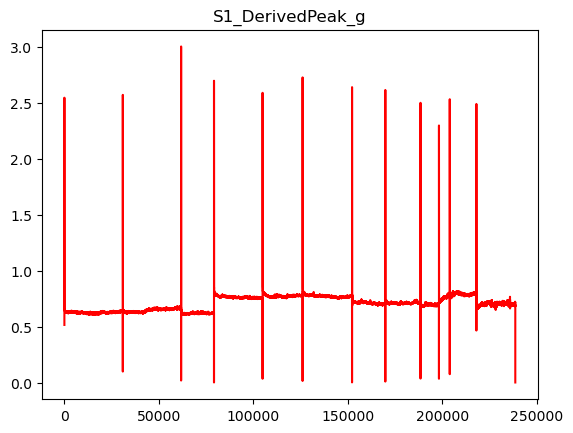

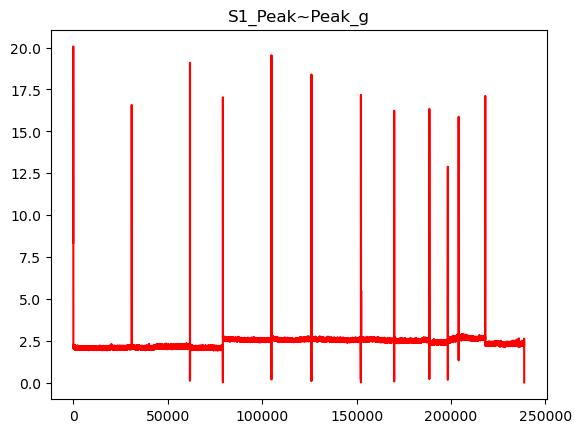

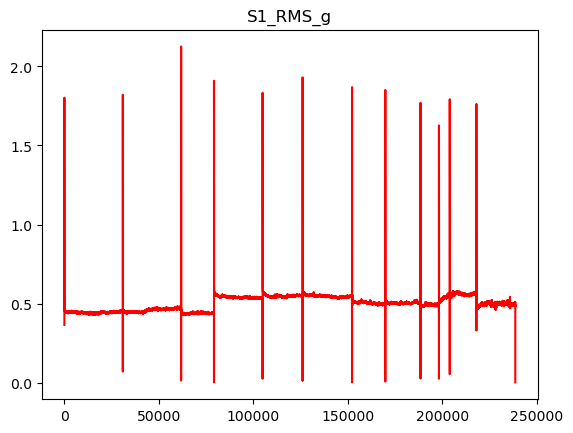

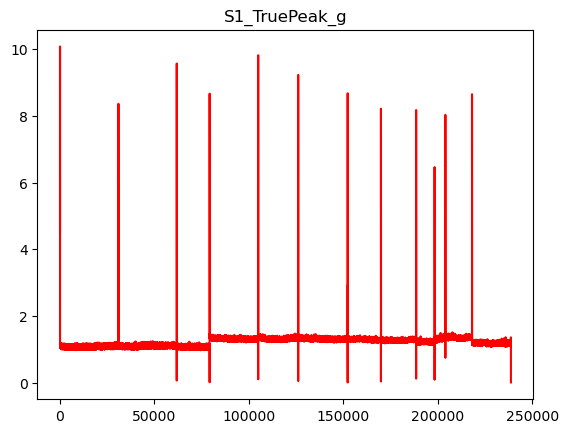

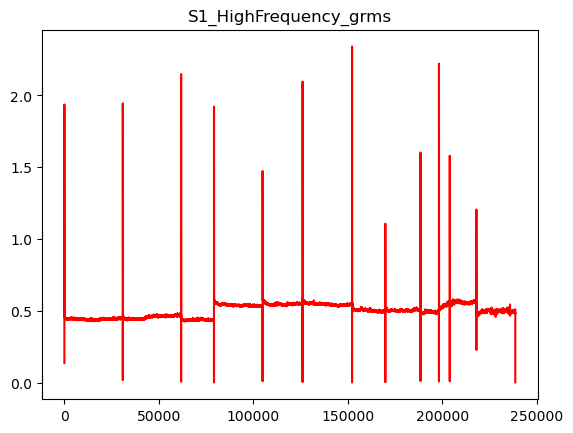

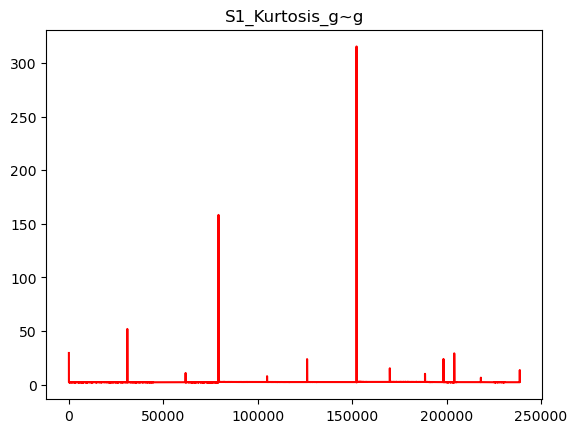

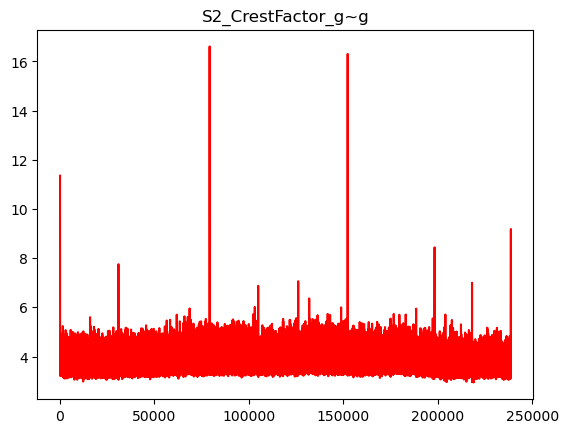

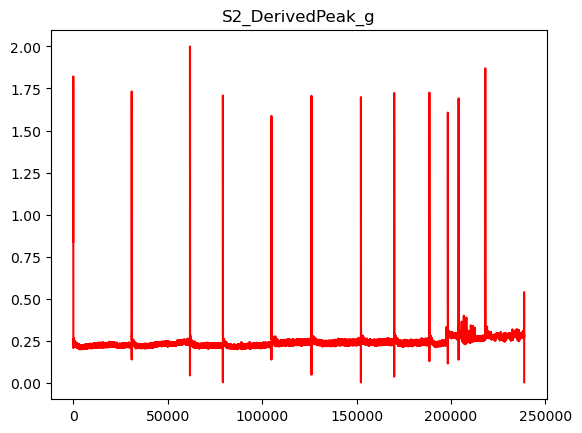

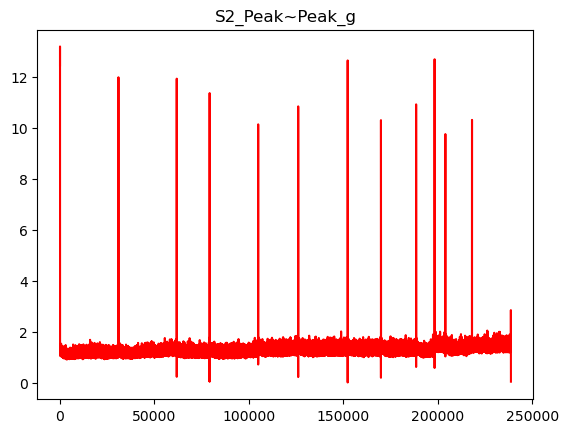

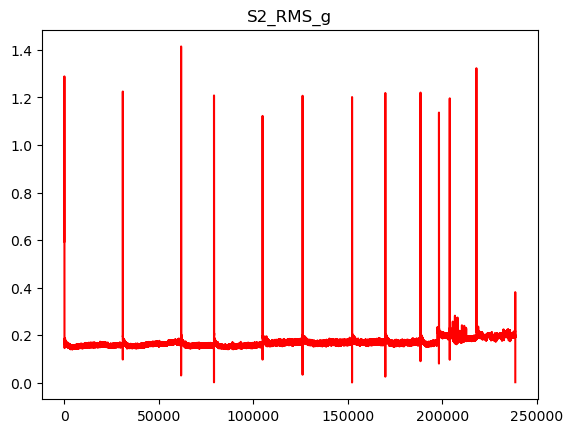

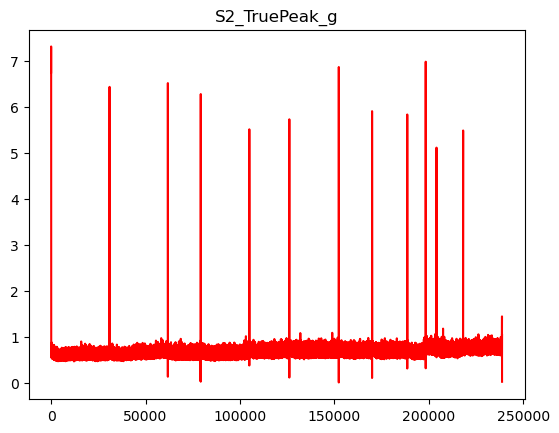

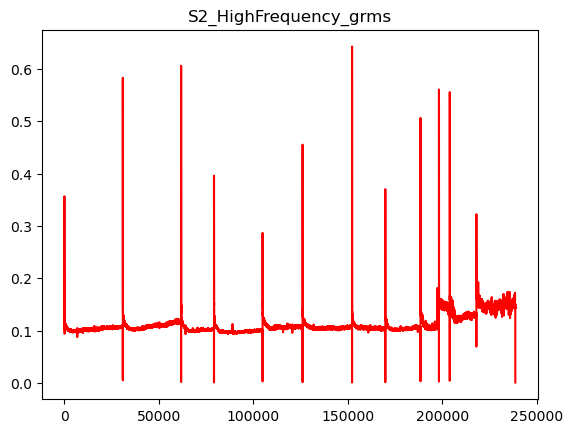

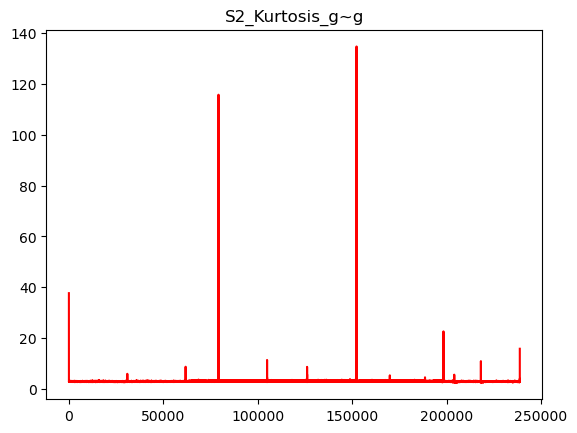

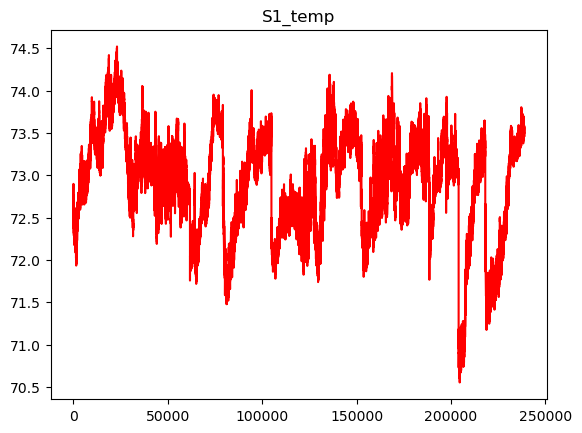

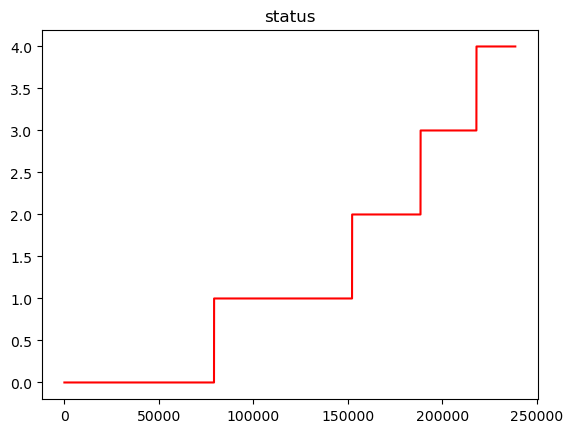

In [35]:

for i in df.columns[1:-1]:
    
    y=df[[i]].values
    


    x = range(0,len(y))

    plt.title("Line graph")
    plt.plot(x, y, color="red")
    plt.title(str(i))

    plt.show()

In [36]:
# Get X & y
# Naming convention: X as predictors; y as response.
from sklearn.model_selection import train_test_split

y = df[['status','rul']] # pop response




X = df.drop('rul',axis = 1) # drop response

print (X.shape)
print (X.columns)

(238722, 16)
Index(['S1_CrestFactor_g~g', 'S1_DerivedPeak_g', 'S1_Peak~Peak_g', 'S1_RMS_g',
       'S1_TruePeak_g', 'S1_HighFrequency_grms', 'S1_Kurtosis_g~g',
       'S2_CrestFactor_g~g', 'S2_DerivedPeak_g', 'S2_Peak~Peak_g', 'S2_RMS_g',
       'S2_TruePeak_g', 'S2_HighFrequency_grms', 'S2_Kurtosis_g~g', 'S1_temp',
       'status'],
      dtype='object')


# FAKE SPLIT TO REUSE CODE

ALL DATA IS KEPT UNDER THE TRAINING DATA VARIABLE. THIS INFO IS FIRST TRANSFORMED INTO SERIES OF 3 DIMENSIONAL ARRAYS AND THEN SPLIT IT BY A TRAIN_TEST_SPLIT

In [37]:
## true orignal ones
# data split

# set aside 20% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.001, shuffle = False, random_state = RNDSEED)

# Use the same function above for the validation set
X_train, X_vals, y_train, y_vals = train_test_split(X_train, y_train, 
    test_size=0.001, random_state= RNDSEED,shuffle=False) # 0.25 x 0.8 = 0.2




In [38]:
238722-X_test.shape[1]-X_vals.shape[1]

238690

In [39]:
df

,S1_CrestFactor_g~g,S1_DerivedPeak_g,S1_Peak~Peak_g,S1_RMS_g,S1_TruePeak_g,S1_HighFrequency_grms,S1_Kurtosis_g~g,S2_CrestFactor_g~g,S2_DerivedPeak_g,S2_Peak~Peak_g,S2_RMS_g,S2_TruePeak_g,S2_HighFrequency_grms,S2_Kurtosis_g~g,S1_temp,status,rul
0,12.3214,0.5170,8.3688,0.3655,4.5040,0.1355,29.4402,11.3516,0.8401,12.4549,0.5941,6.7436,0.1040,37.6491,72.4676,0,2009308.0
1,5.5933,2.5483,20.0644,1.8019,10.0786,1.9368,8.9174,5.6735,1.8216,13.1957,1.2881,7.3079,0.2197,5.0971,72.4427,0,2009307.0
2,4.0140,2.5484,14.3660,1.8020,7.2333,1.6188,5.0306,7.7328,1.2040,11.7569,0.8513,6.5833,0.3566,12.4059,72.4770,0,2009306.0
3,2.6487,0.6943,2.5795,0.4910,1.3004,0.4809,2.2368,3.7461,0.2835,1.4845,0.2004,0.7508,0.1578,2.8937,72.4549,0,2009305.0
4,2.5022,0.6752,2.3616,0.4774,1.1946,0.4748,2.2111,3.7041,0.2932,1.4761,0.2073,0.7679,0.1620,2.7997,72.4988,0,2009304.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238717,2.5083,0.6880,2.3624,0.4865,1.2203,0.4834,2.1624,3.5082,0.2728,1.2713,0.1929,0.6767,0.1447,2.7364,73.5386,4,21.0
238718,2.3925,0.6879,2.2706,0.4864,1.1638,0.4837,2.1555,3.2138,0.2856,1.2836,0.2020,0.6491,0.1457,2.7667,73.5767,4,20.0
238719,5.7067,0.2556,2.0422,0.1808,1.0315,0.0308,13.5090,5.3715,0.1918,1.3841,0.1356,0.7285,0.0184,3.9787,73.5347,4,19.0
238720,4.2261,0.0406,0.2402,0.0287,0.1215,0.0115,3.1910,4.3151,0.1361,0.7445,0.0963,0.4154,0.0036,3.2765,73.5728,4,18.0


# Lets Take a Look to the data!

In [40]:
y_train=pd.DataFrame(y_train,columns = df.columns[-2:])
y_vals=pd.DataFrame(y_vals,columns = df.columns[-2:])
y_test=pd.DataFrame(y_test,columns = df.columns[-2:])

In [41]:
X_train

,S1_CrestFactor_g~g,S1_DerivedPeak_g,S1_Peak~Peak_g,S1_RMS_g,S1_TruePeak_g,S1_HighFrequency_grms,S1_Kurtosis_g~g,S2_CrestFactor_g~g,S2_DerivedPeak_g,S2_Peak~Peak_g,S2_RMS_g,S2_TruePeak_g,S2_HighFrequency_grms,S2_Kurtosis_g~g,S1_temp,status
0,12.3214,0.5170,8.3688,0.3655,4.5040,0.1355,29.4402,11.3516,0.8401,12.4549,0.5941,6.7436,0.1040,37.6491,72.4676,0
1,5.5933,2.5483,20.0644,1.8019,10.0786,1.9368,8.9174,5.6735,1.8216,13.1957,1.2881,7.3079,0.2197,5.0971,72.4427,0
2,4.0140,2.5484,14.3660,1.8020,7.2333,1.6188,5.0306,7.7328,1.2040,11.7569,0.8513,6.5833,0.3566,12.4059,72.4770,0
3,2.6487,0.6943,2.5795,0.4910,1.3004,0.4809,2.2368,3.7461,0.2835,1.4845,0.2004,0.7508,0.1578,2.8937,72.4549,0
4,2.5022,0.6752,2.3616,0.4774,1.1946,0.4748,2.2111,3.7041,0.2932,1.4761,0.2073,0.7679,0.1620,2.7997,72.4988,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238239,2.3484,0.7049,2.3056,0.4985,1.1706,0.4984,2.1560,3.7048,0.2853,1.4410,0.2017,0.7473,0.1556,2.7833,73.4316,4
238240,2.3505,0.7039,2.3207,0.4977,1.1699,0.4965,2.1556,3.3104,0.2844,1.2911,0.2011,0.6657,0.1544,2.7310,73.4484,4
238241,2.4693,0.7040,2.3776,0.4978,1.2292,0.4957,2.1611,3.5026,0.2870,1.4054,0.2030,0.7109,0.1553,2.7390,73.5186,4
238242,2.3349,0.7011,2.3051,0.4957,1.1574,0.4940,2.1562,3.6600,0.2774,1.3829,0.1961,0.7178,0.1519,2.7795,73.4626,4


# LSTM

In [42]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.layers import Dropout,Conv1D,MaxPooling1D,Flatten, Activation, Dense
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf
from datetime import datetime
from tensorflow.keras.layers import Dropout,Conv1D,MaxPooling1D,Flatten, Activation
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from autosklearn.regression import AutoSklearnRegressor
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.regularizers import L2,L1,L1L2

2023-07-01 14:40:39.603205: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-01 14:40:40.276363: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [43]:
X_train#.shape

,S1_CrestFactor_g~g,S1_DerivedPeak_g,S1_Peak~Peak_g,S1_RMS_g,S1_TruePeak_g,S1_HighFrequency_grms,S1_Kurtosis_g~g,S2_CrestFactor_g~g,S2_DerivedPeak_g,S2_Peak~Peak_g,S2_RMS_g,S2_TruePeak_g,S2_HighFrequency_grms,S2_Kurtosis_g~g,S1_temp,status
0,12.3214,0.5170,8.3688,0.3655,4.5040,0.1355,29.4402,11.3516,0.8401,12.4549,0.5941,6.7436,0.1040,37.6491,72.4676,0
1,5.5933,2.5483,20.0644,1.8019,10.0786,1.9368,8.9174,5.6735,1.8216,13.1957,1.2881,7.3079,0.2197,5.0971,72.4427,0
2,4.0140,2.5484,14.3660,1.8020,7.2333,1.6188,5.0306,7.7328,1.2040,11.7569,0.8513,6.5833,0.3566,12.4059,72.4770,0
3,2.6487,0.6943,2.5795,0.4910,1.3004,0.4809,2.2368,3.7461,0.2835,1.4845,0.2004,0.7508,0.1578,2.8937,72.4549,0
4,2.5022,0.6752,2.3616,0.4774,1.1946,0.4748,2.2111,3.7041,0.2932,1.4761,0.2073,0.7679,0.1620,2.7997,72.4988,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238239,2.3484,0.7049,2.3056,0.4985,1.1706,0.4984,2.1560,3.7048,0.2853,1.4410,0.2017,0.7473,0.1556,2.7833,73.4316,4
238240,2.3505,0.7039,2.3207,0.4977,1.1699,0.4965,2.1556,3.3104,0.2844,1.2911,0.2011,0.6657,0.1544,2.7310,73.4484,4
238241,2.4693,0.7040,2.3776,0.4978,1.2292,0.4957,2.1611,3.5026,0.2870,1.4054,0.2030,0.7109,0.1553,2.7390,73.5186,4
238242,2.3349,0.7011,2.3051,0.4957,1.1574,0.4940,2.1562,3.6600,0.2774,1.3829,0.1961,0.7178,0.1519,2.7795,73.4626,4


In [44]:
# X_train.shape
# np.c_[m, v]
X_train

,S1_CrestFactor_g~g,S1_DerivedPeak_g,S1_Peak~Peak_g,S1_RMS_g,S1_TruePeak_g,S1_HighFrequency_grms,S1_Kurtosis_g~g,S2_CrestFactor_g~g,S2_DerivedPeak_g,S2_Peak~Peak_g,S2_RMS_g,S2_TruePeak_g,S2_HighFrequency_grms,S2_Kurtosis_g~g,S1_temp,status
0,12.3214,0.5170,8.3688,0.3655,4.5040,0.1355,29.4402,11.3516,0.8401,12.4549,0.5941,6.7436,0.1040,37.6491,72.4676,0
1,5.5933,2.5483,20.0644,1.8019,10.0786,1.9368,8.9174,5.6735,1.8216,13.1957,1.2881,7.3079,0.2197,5.0971,72.4427,0
2,4.0140,2.5484,14.3660,1.8020,7.2333,1.6188,5.0306,7.7328,1.2040,11.7569,0.8513,6.5833,0.3566,12.4059,72.4770,0
3,2.6487,0.6943,2.5795,0.4910,1.3004,0.4809,2.2368,3.7461,0.2835,1.4845,0.2004,0.7508,0.1578,2.8937,72.4549,0
4,2.5022,0.6752,2.3616,0.4774,1.1946,0.4748,2.2111,3.7041,0.2932,1.4761,0.2073,0.7679,0.1620,2.7997,72.4988,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238239,2.3484,0.7049,2.3056,0.4985,1.1706,0.4984,2.1560,3.7048,0.2853,1.4410,0.2017,0.7473,0.1556,2.7833,73.4316,4
238240,2.3505,0.7039,2.3207,0.4977,1.1699,0.4965,2.1556,3.3104,0.2844,1.2911,0.2011,0.6657,0.1544,2.7310,73.4484,4
238241,2.4693,0.7040,2.3776,0.4978,1.2292,0.4957,2.1611,3.5026,0.2870,1.4054,0.2030,0.7109,0.1553,2.7390,73.5186,4
238242,2.3349,0.7011,2.3051,0.4957,1.1574,0.4940,2.1562,3.6600,0.2774,1.3829,0.1961,0.7178,0.1519,2.7795,73.4626,4


0         2009308.0
1         2009307.0
2         2009306.0
3         2009305.0
4         2009304.0
            ...    
238239        499.0
238240        498.0
238241        497.0
238242        496.0
238243        495.0
Name: rul, Length: 238244, dtype: float64
range(0, 238244)


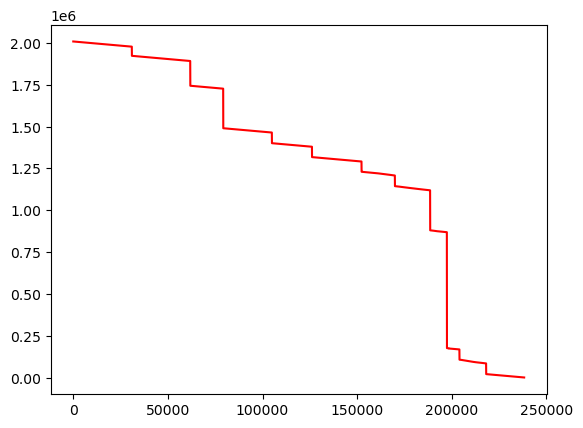

In [45]:
plt.plot( range(0,len(y_train['rul'])),y_train['rul'] ,color='red')


print(y_train['rul'] )
print(range(0,len(y_train['rul'])))

0         1.000000
1         0.999996
2         0.999992
3         0.999987
4         0.999983
            ...   
238239    0.000017
238240    0.000013
238241    0.000008
238242    0.000004
238243    0.000000
Name: rul, Length: 238244, dtype: float64
range(0, 238244)


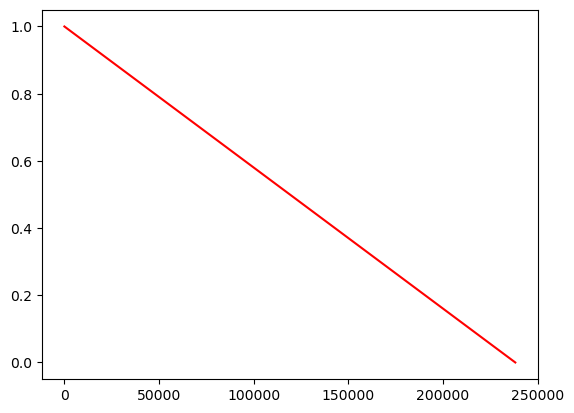

In [46]:
from sklearn.preprocessing import StandardScaler
from scipy.signal import medfilt
import pandas as pd
def NormalizeData(data):
    return 1-(data - np.min(data)) / (np.max(data) - np.min(data))



scaler=StandardScaler()
X_train=pd.DataFrame(scaler.fit_transform(X_train),columns = df.columns[:-1])




model = np.poly1d(np.polyfit(range(0,len(y_train['rul'])), y_train['rul'], 1))
polyline = np.array(np.linspace(0,len(y_train['rul']),len(y_train['rul']) ) )

## Using Oldest - current to determine the RUL
y_train['rul'] = NormalizeData(polyline)
#ADDING A FILTER TO SMOOTHEN CURVE
plt.plot( range(0,len(y_train['rul'])),y_train['rul'] ,color='red')


print(y_train['rul'] )
print(range(0,len(y_train['rul'])))

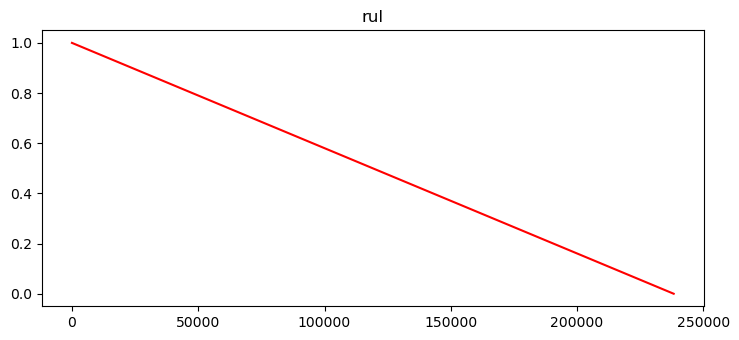

In [47]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

plt.title("Line graph")
plt.title("rul")
plt.plot(range(0,len(y_train['rul'])),y_train['rul'], color="red")





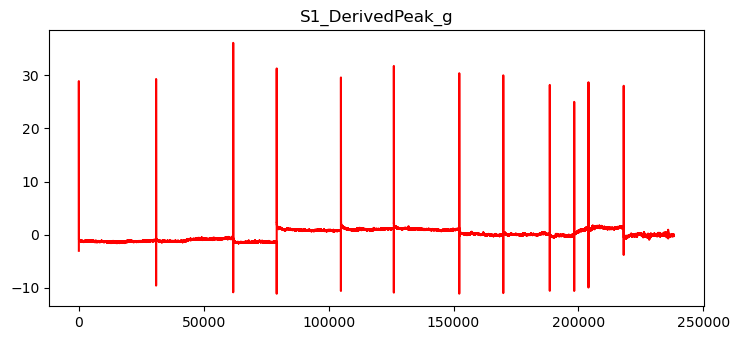

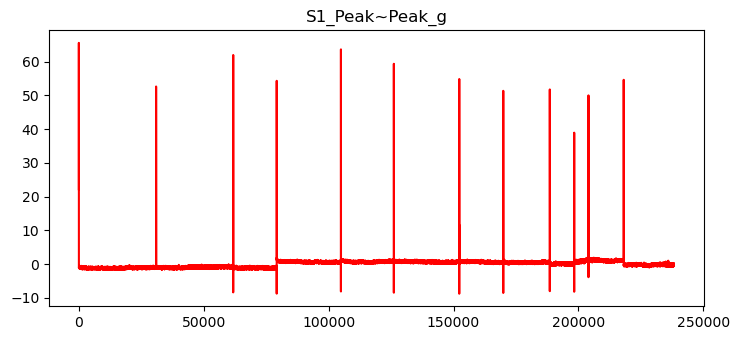

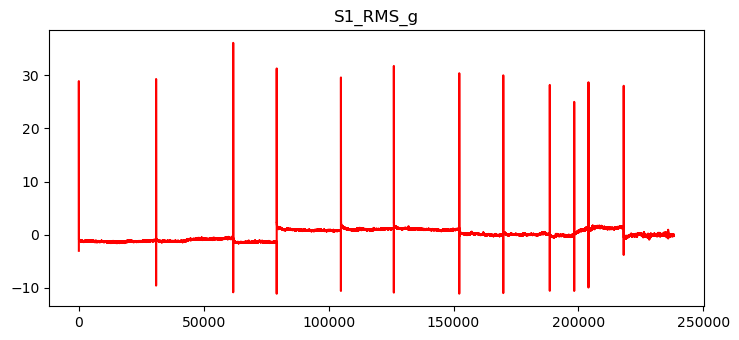

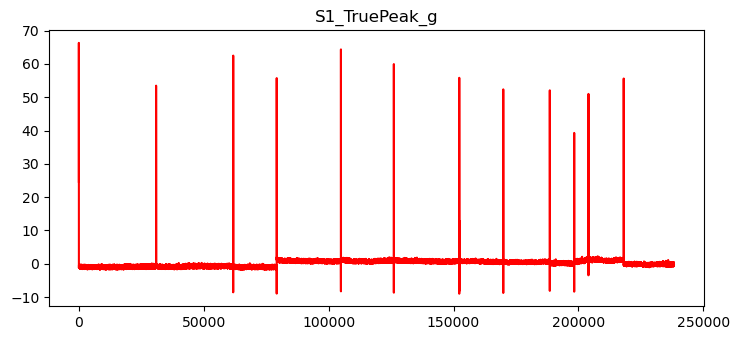

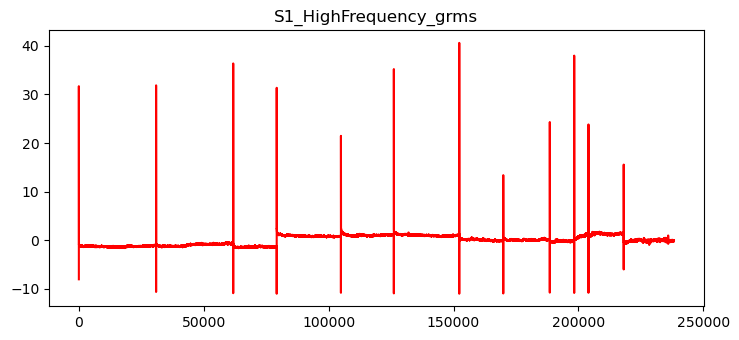

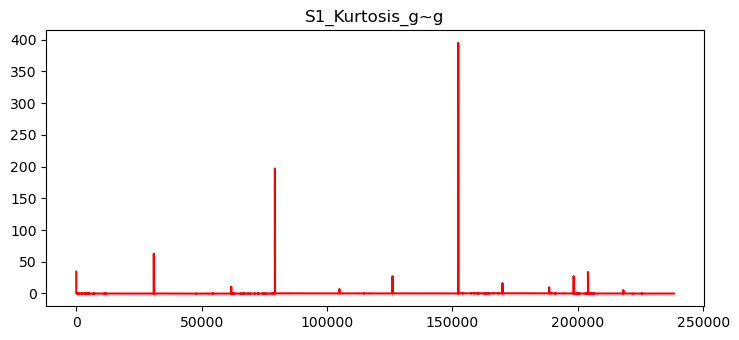

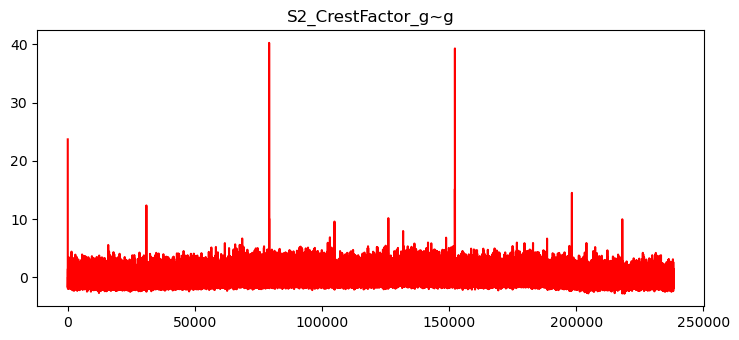

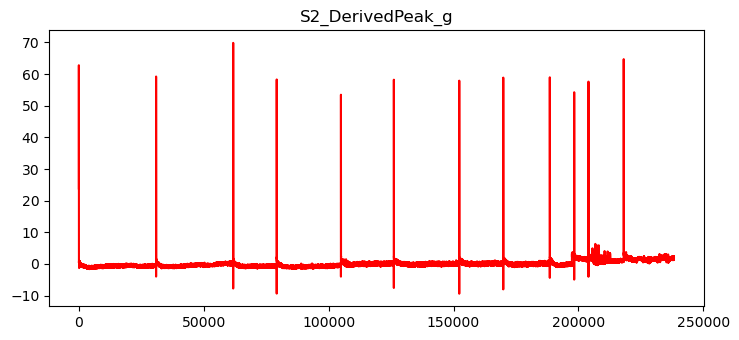

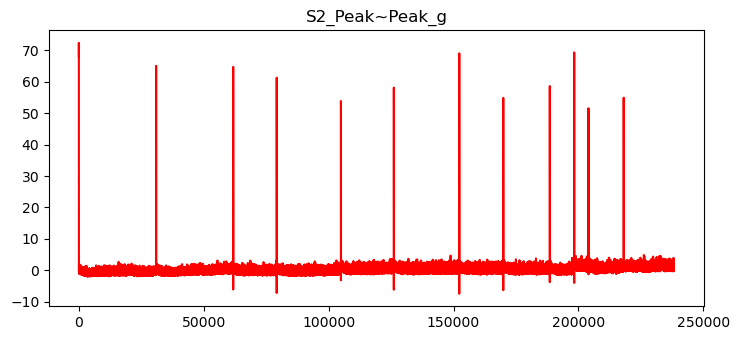

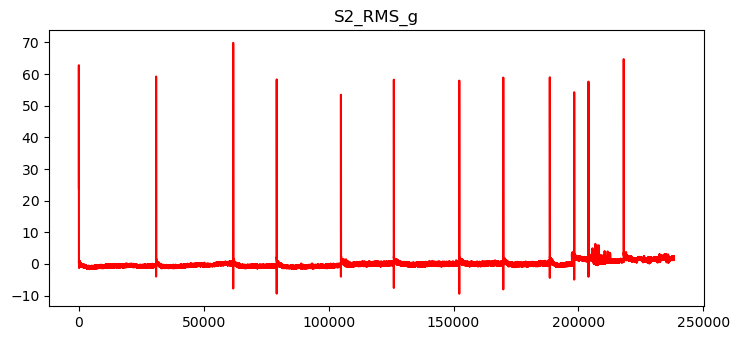

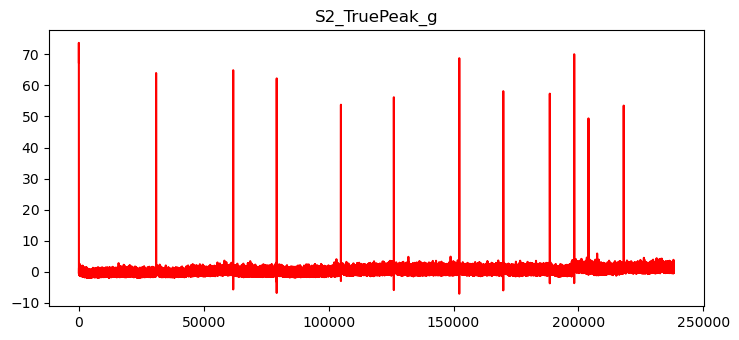

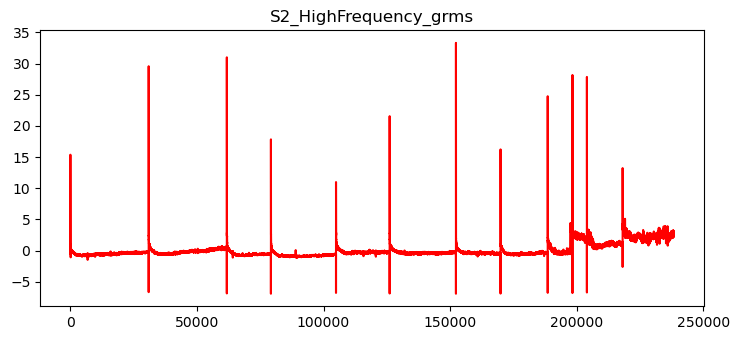

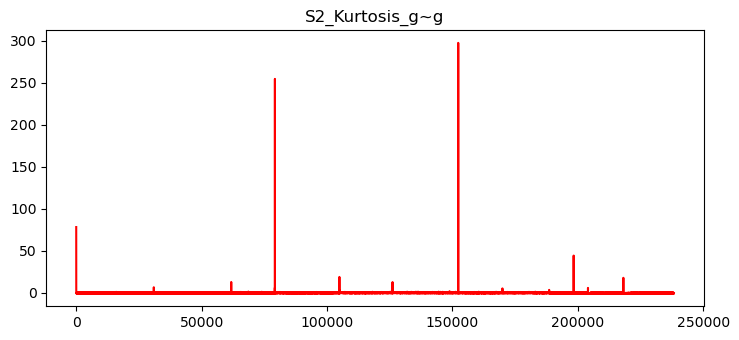

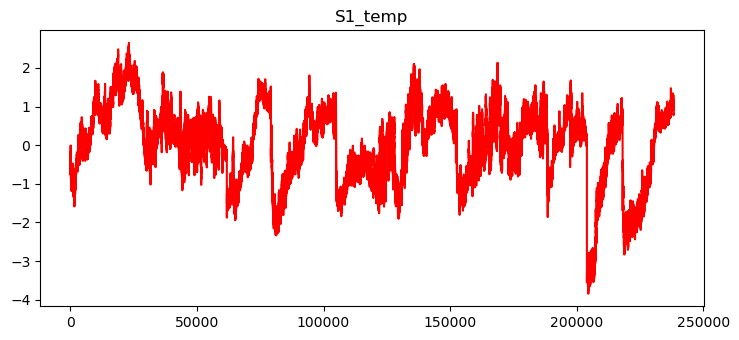

In [48]:

for i in X_train.columns[1:-1]:
    
    y=X_train[[i]].values
    


    x = range(0,len(y))

    plt.title("Line graph")
    plt.plot(x, y, color="red")
    plt.title(str(i))

    plt.show()

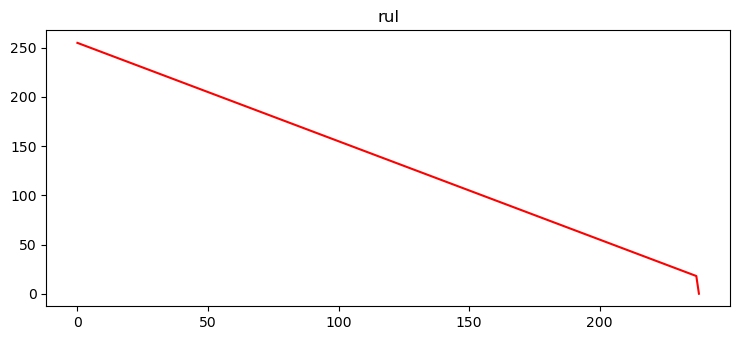

In [49]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

plt.title("Line graph")
plt.title("rul")
plt.plot(range(0,len(y_test['rul'])),y_test['rul'], color="red")





# SEQUENCE LEGHT

In [50]:
seq_length=200
#STEPS_PER_BATCH=#X_vals.shape[0] IF 60 MINS OF DATA THEN 3600


###### LSTMs and Sequences:
LSTM models need 3 dimentional inputs (number of data rows, sequence_length, number of features). This because we need the LSTM to take a sequence of data (for example 200 secs of data) and from this sequence, we want the LSTM model to predict the RUL. These 3 inputs provide the LSTM model all the information about the tendancies and variations in the data for this period, which gives the LSTM model an idea about the state of the motor. This is a strength of LSTM models. They take a degradation period of the motor and determines how much the motor has degraded (percent of life left or RUL as a percent). 

For this RUL model we will take 200 seconds of data (sequence_length = 200). We can take more if we desire, but the more data we take the longer the computation time will be.

In [51]:
def gen_seq(data, seq_length, columns):
    L=[]
    n = data.shape[0]
    for i in range(0, n - seq_length):
        L.append(data[i:i+seq_length][columns].values)
    return(L)

###### Homogeneity of Sequences:
For LSTM models, the sequences should be homogeneous. To accomplish this, we generate the sequences depending on the status. We split each status to into sequences, and then join them into one array in the cells below (for train and test datasets).

(data, seq_length, columns):

data = train_data[train_data['status'] == id

seq_length = 200

columns = [... tabular columns...,"status"]

In [52]:
#INCLUSION OF STATUS

In [53]:
columns=df.columns[:-2]
columns

Index(['S1_CrestFactor_g~g', 'S1_DerivedPeak_g', 'S1_Peak~Peak_g', 'S1_RMS_g',
       'S1_TruePeak_g', 'S1_HighFrequency_grms', 'S1_Kurtosis_g~g',
       'S2_CrestFactor_g~g', 'S2_DerivedPeak_g', 'S2_Peak~Peak_g', 'S2_RMS_g',
       'S2_TruePeak_g', 'S2_HighFrequency_grms', 'S2_Kurtosis_g~g', 'S1_temp'],
      dtype='object')

In [54]:
columns.shape

(15,)

In [55]:
target=df.columns[-1]
target

'rul'

In [56]:
X_train.shape

(238244, 16)

In [57]:
X_train

,S1_CrestFactor_g~g,S1_DerivedPeak_g,S1_Peak~Peak_g,S1_RMS_g,S1_TruePeak_g,S1_HighFrequency_grms,S1_Kurtosis_g~g,S2_CrestFactor_g~g,S2_DerivedPeak_g,S2_Peak~Peak_g,S2_RMS_g,S2_TruePeak_g,S2_HighFrequency_grms,S2_Kurtosis_g~g,S1_temp,status
0,73.740707,-3.026359,22.219073,-3.028011,24.615745,-8.041372,34.278640,23.682092,23.850742,67.913348,23.854127,67.459358,-0.461781,78.385604,-0.712209,-1.032459
1,23.641307,28.884864,65.579225,28.884447,66.318186,31.694392,8.397912,5.800568,62.775967,72.401607,62.778011,73.702569,6.793609,4.958206,-0.752972,-1.032459
2,11.881378,28.886435,44.453034,28.886669,45.033079,24.679474,3.496377,12.285734,38.282621,63.684400,38.279520,65.685856,15.378423,21.444633,-0.696820,-1.032459
3,1.714955,-0.241019,0.755880,-0.239781,0.650269,-0.422023,-0.026806,-0.269218,1.776589,1.447375,1.772955,1.157183,2.911944,-0.011993,-0.732999,-1.032459
4,0.624073,-0.541076,-0.051961,-0.541932,-0.141200,-0.556586,-0.059216,-0.401485,2.161281,1.396482,2.159950,1.346371,3.175321,-0.224029,-0.661132,-1.032459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238239,-0.521167,-0.074496,-0.259575,-0.073154,-0.320739,-0.035982,-0.128701,-0.399280,1.847975,1.183823,1.845867,1.118460,2.773985,-0.261022,0.865932,2.092788
238240,-0.505529,-0.090206,-0.203593,-0.090928,-0.325975,-0.077895,-0.129205,-1.641328,1.812282,0.275629,1.812215,0.215667,2.698735,-0.378995,0.893435,2.092788
238241,0.379090,-0.088635,0.007358,-0.088706,0.117636,-0.095543,-0.122269,-1.036050,1.915395,0.968135,1.918779,0.715744,2.755173,-0.360949,1.008358,2.092788
238242,-0.621692,-0.134193,-0.261428,-0.135361,-0.419485,-0.133044,-0.128448,-0.540365,1.534670,0.831815,1.531784,0.792083,2.541963,-0.269594,0.916682,2.092788


In [58]:
y_train

,status,rul
0,0,1.000000
1,0,0.999996
2,0,0.999992
3,0,0.999987
4,0,0.999983
...,...,...
238239,4,0.000017
238240,4,0.000013
238241,4,0.000008
238242,4,0.000004


In [59]:
238244

238244

# Data Vizualization!

In [60]:
vizu=pd.merge(left=X_train.iloc[:,:-1],right=y_train,left_index=True,right_index=True)

In [61]:
status_map = {
    0:"No_Offset",
    1:"1mm_Offset",
    2:"3mm_Offset",
    3:"6.25mm_Offset",
    4:"12.7mm_Offset",
}

vizu["status"] = vizu["status"].map(status_map)

In [62]:

vizu

,S1_CrestFactor_g~g,S1_DerivedPeak_g,S1_Peak~Peak_g,S1_RMS_g,S1_TruePeak_g,S1_HighFrequency_grms,S1_Kurtosis_g~g,S2_CrestFactor_g~g,S2_DerivedPeak_g,S2_Peak~Peak_g,S2_RMS_g,S2_TruePeak_g,S2_HighFrequency_grms,S2_Kurtosis_g~g,S1_temp,status,rul
0,73.740707,-3.026359,22.219073,-3.028011,24.615745,-8.041372,34.278640,23.682092,23.850742,67.913348,23.854127,67.459358,-0.461781,78.385604,-0.712209,No_Offset,1.000000
1,23.641307,28.884864,65.579225,28.884447,66.318186,31.694392,8.397912,5.800568,62.775967,72.401607,62.778011,73.702569,6.793609,4.958206,-0.752972,No_Offset,0.999996
2,11.881378,28.886435,44.453034,28.886669,45.033079,24.679474,3.496377,12.285734,38.282621,63.684400,38.279520,65.685856,15.378423,21.444633,-0.696820,No_Offset,0.999992
3,1.714955,-0.241019,0.755880,-0.239781,0.650269,-0.422023,-0.026806,-0.269218,1.776589,1.447375,1.772955,1.157183,2.911944,-0.011993,-0.732999,No_Offset,0.999987
4,0.624073,-0.541076,-0.051961,-0.541932,-0.141200,-0.556586,-0.059216,-0.401485,2.161281,1.396482,2.159950,1.346371,3.175321,-0.224029,-0.661132,No_Offset,0.999983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238239,-0.521167,-0.074496,-0.259575,-0.073154,-0.320739,-0.035982,-0.128701,-0.399280,1.847975,1.183823,1.845867,1.118460,2.773985,-0.261022,0.865932,12.7mm_Offset,0.000017
238240,-0.505529,-0.090206,-0.203593,-0.090928,-0.325975,-0.077895,-0.129205,-1.641328,1.812282,0.275629,1.812215,0.215667,2.698735,-0.378995,0.893435,12.7mm_Offset,0.000013
238241,0.379090,-0.088635,0.007358,-0.088706,0.117636,-0.095543,-0.122269,-1.036050,1.915395,0.968135,1.918779,0.715744,2.755173,-0.360949,1.008358,12.7mm_Offset,0.000008
238242,-0.621692,-0.134193,-0.261428,-0.135361,-0.419485,-0.133044,-0.128448,-0.540365,1.534670,0.831815,1.531784,0.792083,2.541963,-0.269594,0.916682,12.7mm_Offset,0.000004


In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import seaborn as sns



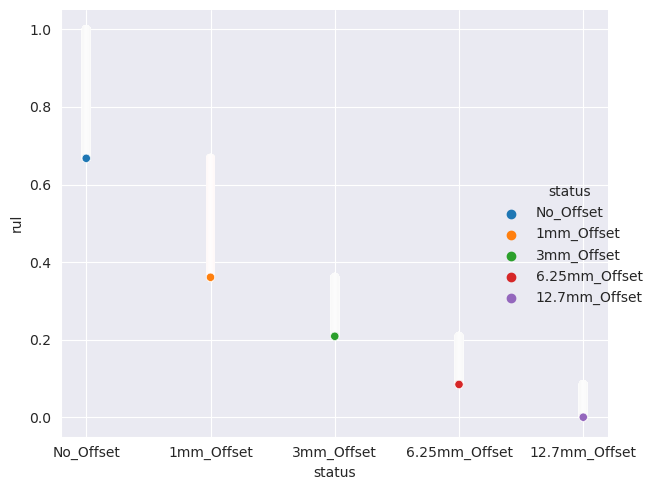

In [64]:
sns.set_style('darkgrid')
# sns.set(rc={'figure.figsize':(14,8)})

# ax = sns.lineplot(data=vizu[:-1], x ='S1_CrestFactor_g~g', y = 'status',
# #                   hue='District', palette='viridis',
#                   legend='full')#, lw=3

# # ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
# # plt.legend(bbox_to_anchor=(1, 1))
# plt.ylabel('PM2.5 (µg/m3)')
# plt.xlabel('Year-Month')
# plt.show()
# vizu.hist(figsize=(15,30),layout=(9,3))
sns.relplot(data=vizu[:], x="status", y="rul", hue="status",legend='full')

In [65]:
# sns.set_style("darkgrid");
# # sns.pairplot(vizu.iloc[:,:-1], hue="status", size=3);
# # plt.show()
# sns.relplot(data=vizu.iloc[:,:-1],x='S1_CrestFactor_g~g', y="status", kind="line")


In [66]:
# # plt.figure(figsize=(10,5))
# # plt.xlim(0,1000)
# # plt.ylabel('rul')
# # sns.boxplot(x=df['rul'])
# # plt.show()



# # set limits
# plt.xlim(0,10) 
# plt.ylim(0,10)

# for i in range(10):        
#      # add something to axes    
#     ax.scatter([i], [i]) 
#     ax.plot([i], [i+1], 'rx')

#      # draw the plot
#      plt.draw() 
#      plt.pause(0.01) #is necessary for the plot to update for some reason

#      # start removing points if you don't want all shown
#         if i>2:
#          ax.lines[0].remove()
#          ax.collections[0].remove()
#         for i in range(10):

            
            
#             plt.figure(i+1) #to let the index start at 1
# plt.plot(t, signal())
# plt.show()


# plt.subplot(121)
# plt.plot(t, "r--")
# plt.xlabel("Graph 1")
 
# plt.subplot(122)
# plt.plot(t, "r--", t**2, "b+", t**3, "g-o")
# plt.xlabel("Graph 1")
 
# plt.suptitle("Plotting Multiple Graphs")
# plt.show()



# x = range(3)
# y = range(5)

# fig, ax = plt.subplots(nrows=2, ncols=2)

# for row in ax:
#     for col in row:
#         col.plot(x, y)

# plt.show()

In [67]:
# len(X_train.columns[:-1])

In [68]:
# x = range(5)
# y = range(5)

# fig, ax = plt.subplots(nrows=5, ncols=3)

# for row in ax:
#     for col in row:
#         col.plot(x, y)

In [69]:
# sns.set_theme()
# sns.set_style('darkgrid')



# fig, ax = plt.subplots(nrows=5, ncols=3)


# counter=0
# for row in ax:
#     for col in row:
        
#         column_name=X_train.columns[:-1][i]
#         print(column_name)
#         y=vizu[[column_name]].values
#         x = range(0,len(y))
#         plt.xlabel(str(column_name))
#         plt.plot(x, y, color="red")
#         counter=counter+1
#         print(counter)
        
# #         col.plot(x, y)
        
        
        
# # for i in range(10):
# # #     ax.scatter([i], [i]) 
# # #     ax.plot([i], [i+1], 'rx')
    
# # #     plt.draw()
# # #     plt.pause(0.01)
    
# # #     if i>2:
        
# # # #         ax.lines[0].remove()
# # # #         ax.collections[0].remove()

    
    
    
    

# #     column_name=X_train.columns[:-1][i]
# #     y=vizu[[column_name]].values
# #     x = range(0,len(y))
# #     plt.xlabel(str(column_name))
# #     plt.plot(x, y, color="red")
# # #     plt.title()
        


# # #         plt.show()

Index(['S1_CrestFactor_g~g', 'S1_DerivedPeak_g', 'S1_Peak~Peak_g', 'S1_RMS_g',
       'S1_TruePeak_g', 'S1_HighFrequency_grms', 'S1_Kurtosis_g~g',
       'S2_CrestFactor_g~g', 'S2_DerivedPeak_g', 'S2_Peak~Peak_g', 'S2_RMS_g',
       'S2_TruePeak_g', 'S2_HighFrequency_grms', 'S2_Kurtosis_g~g', 'S1_temp'],
      dtype='object')


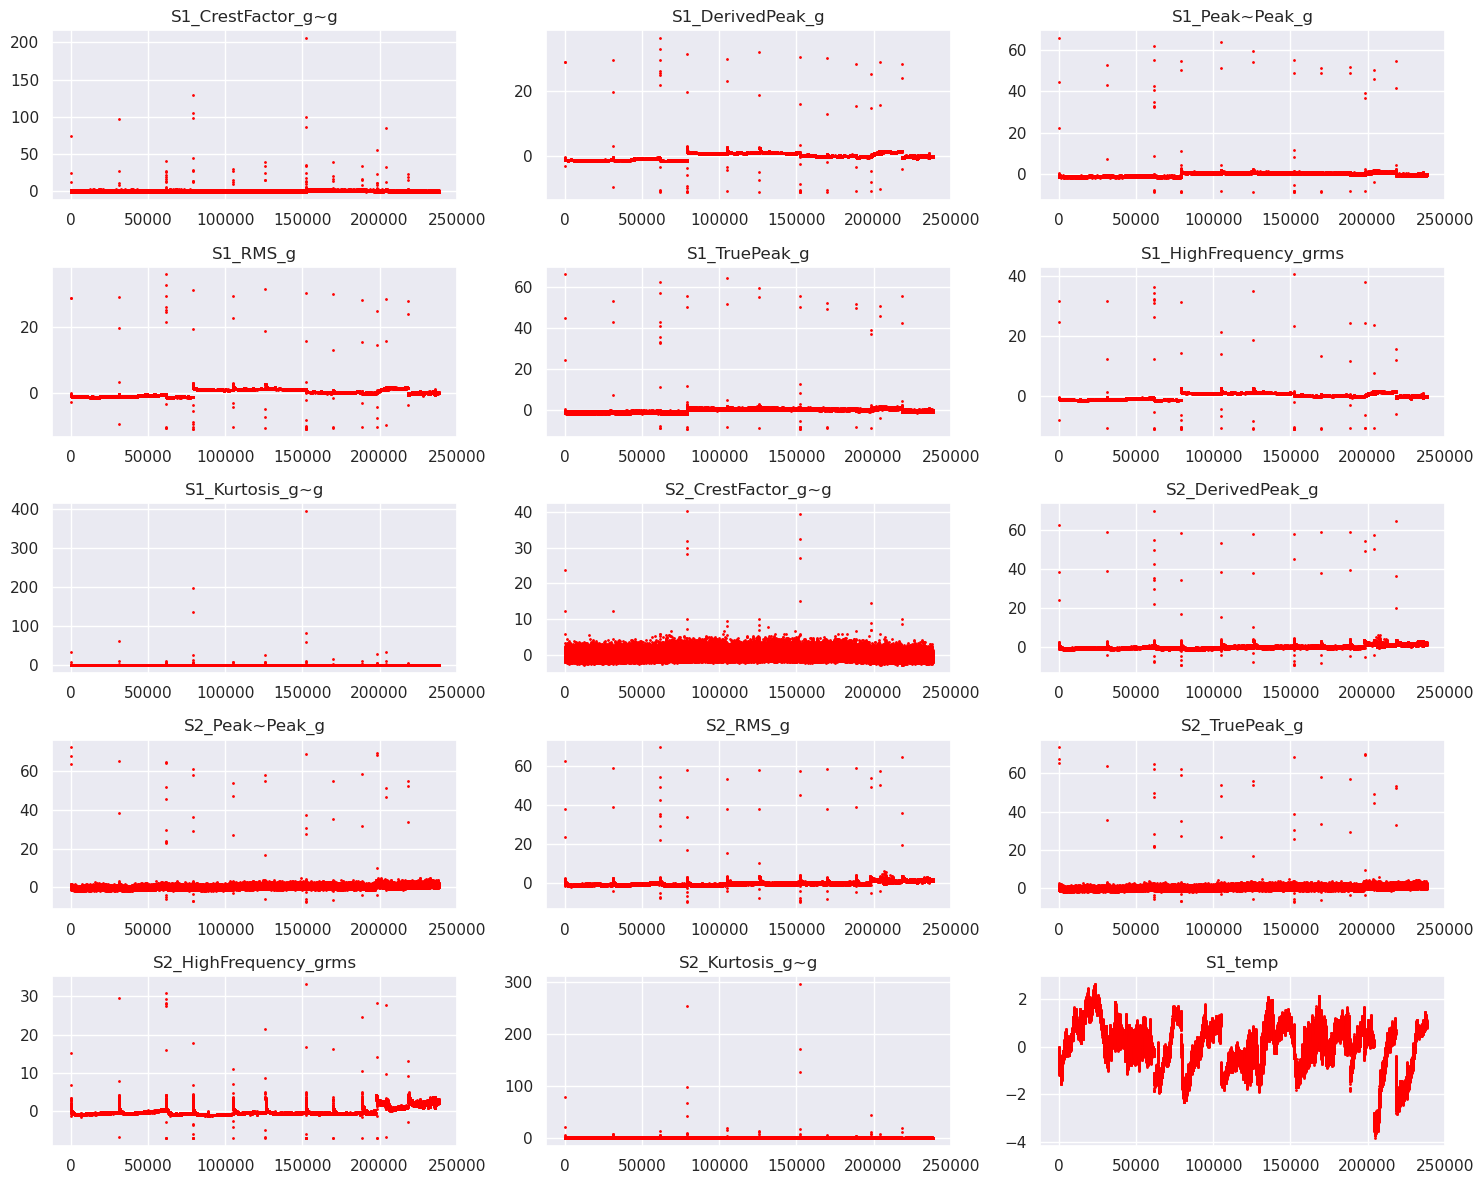

In [70]:
# define subplot grid
sns.set_theme()
sns.set_style('darkgrid')

fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
# fig.suptitle("Daily closing prices", fontsize=18, y=0.95)
tickers=X_train.columns[:-1]
print(tickers)
# loop through tickers and axes
for ticker, ax in zip(tickers, axs.ravel()):
    
    column_name=ticker#X_train.columns[:-1][]
#     print(column_name)
    y=vizu[column_name].values
    x = range(0,len(y))
    ax.scatter(x, y, color="red",s=1)
#     plt.draw()
#     plt.pause(1e-17)
#     time.sleep(0.1)
    # filter df for ticker and plot on specified axes
#     df[df["ticker"] == ticker].plot(ax=ax)

    # chart formatting
    ax.set_title(ticker)
#     ax.get_legend().remove()
#     ax.set_xlabel("")

plt.show()

In [71]:
# sns.set_theme()
# sns.set_style('no color')
# corr_matrix=vizu.iloc[:,:-2].corr()
# fig_cor, axes_cor = plt.subplots(1,1)
# fig_cor.set_size_inches(16, 16)



# labels=vizu.iloc[:,:-2].columns


# myimage = axes_cor.imshow(corr_matrix)

# plt.colorbar(myimage)

# # axes_cor.set_xticks(np.arange(0,corr_matrix.shape[0], corr_matrix.shape[0]*1.0/len(labels)))
# # axes_cor.set_yticks(np.arange(0,corr_matrix.shape[1], corr_matrix.shape[1]*1.0/len(labels)))

# axes_cor.set_xticklabels(labels,)
# axes_cor.set_yticklabels(labels)

# plt.draw()



In [72]:

# corr_matrix= np.random.rand(20,20)
# fig_cor, axes_cor = plt.subplots(1,1)
# fig_cor.set_size_inches(6, 6)

# labels = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14','P15'] 

# myimage = axes_cor.imshow(corr_matrix)

# plt.colorbar(myimage)

# axes_cor.set_xticks(np.arange(0,corr_matrix.shape[0], corr_matrix.shape[0]*1.0/len(labels)))
# axes_cor.set_yticks(np.arange(0,corr_matrix.shape[1], corr_matrix.shape[1]*1.0/len(labels)))

# axes_cor.set_xticklabels(labels)
# axes_cor.set_yticklabels(labels)

# plt.draw()

# END OF DATA VIZUALIZATION!

In [73]:

train_inputs = np.concatenate(np.array([gen_seq(X_train[X_train['status'] == id], seq_length, columns)
                               for id in X_train['status'].unique()]))

/tmp/ipykernel_300312/3637815573.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_inputs = np.concatenate(np.array([gen_seq(X_train[X_train['status'] == id], seq_length, columns)


In [74]:
train_inputs.shape

(237244, 200, 15)

In [75]:
train_inputs

array([[[ 7.37407071e+01, -3.02635889e+00,  2.22190734e+01, ...,
         -4.61780690e-01,  7.83856039e+01, -7.12208598e-01],
        [ 2.36413075e+01,  2.88848645e+01,  6.55792255e+01, ...,
          6.79360948e+00,  4.95820596e+00, -7.52971781e-01],
        [ 1.18813779e+01,  2.88864354e+01,  4.44530335e+01, ...,
          1.53784229e+01,  2.14446328e+01, -6.96820088e-01],
        ...,
        [-3.29052276e-01, -9.82519888e-01, -8.74630534e-01, ...,
          1.84118349e-01, -9.07171420e-02, -5.91719833e-01],
        [-9.44940670e-02, -9.87232814e-01, -7.03719848e-01, ...,
          2.28014400e-01, -1.35723580e-02, -5.84680408e-01],
        [ 3.57495879e-01, -9.93516716e-01, -9.54710161e-01, ...,
          1.96660078e-01, -2.80646698e-01, -7.08115909e-01]],

       [[ 2.36413075e+01,  2.88848645e+01,  6.55792255e+01, ...,
          6.79360948e+00,  4.95820596e+00, -7.52971781e-01],
        [ 1.18813779e+01,  2.88864354e+01,  4.44530335e+01, ...,
          1.53784229e+01,  2.14446328e

In [76]:

test_inputs = np.concatenate(np.array([gen_seq(X_test[X_test['status'] == id], seq_length, columns)
                               for id in X_test['status'].unique()]))

In [77]:
test_inputs.shape

(39, 200, 15)

In [78]:

vals_inputs = np.concatenate(np.array([gen_seq(X_vals[X_vals['status'] == id], seq_length, columns)
                               for id in X_vals['status'].unique()]))

In [79]:
vals_inputs.shape

(39, 200, 15)

In [80]:
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements]

In [81]:
train_out = np.concatenate(np.array([gen_labels(y_train[y_train['status'] == id], seq_length, [target])
                               for id in y_train['status'].unique()]))

/tmp/ipykernel_300312/3860507962.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_out = np.concatenate(np.array([gen_labels(y_train[y_train['status'] == id], seq_length, [target])


In [82]:
train_out.shape


(237244, 1)

In [83]:
test_out = np.concatenate(np.array([gen_labels(y_test[y_test['status'] == id], seq_length, [target])
                               for id in y_test['status'].unique()]))

In [84]:
test_out.shape

(39, 1)

In [85]:
vals_out = np.concatenate(np.array([gen_labels(y_vals[y_vals['status'] == id], seq_length, [target])
                               for id in y_vals['status'].unique()]))

In [86]:
vals_out.shape

(39, 1)

# New split based on randomized sequences!

In [87]:
train_inputs.shape

(237244, 200, 15)

In [88]:
train_inputs

array([[[ 7.37407071e+01, -3.02635889e+00,  2.22190734e+01, ...,
         -4.61780690e-01,  7.83856039e+01, -7.12208598e-01],
        [ 2.36413075e+01,  2.88848645e+01,  6.55792255e+01, ...,
          6.79360948e+00,  4.95820596e+00, -7.52971781e-01],
        [ 1.18813779e+01,  2.88864354e+01,  4.44530335e+01, ...,
          1.53784229e+01,  2.14446328e+01, -6.96820088e-01],
        ...,
        [-3.29052276e-01, -9.82519888e-01, -8.74630534e-01, ...,
          1.84118349e-01, -9.07171420e-02, -5.91719833e-01],
        [-9.44940670e-02, -9.87232814e-01, -7.03719848e-01, ...,
          2.28014400e-01, -1.35723580e-02, -5.84680408e-01],
        [ 3.57495879e-01, -9.93516716e-01, -9.54710161e-01, ...,
          1.96660078e-01, -2.80646698e-01, -7.08115909e-01]],

       [[ 2.36413075e+01,  2.88848645e+01,  6.55792255e+01, ...,
          6.79360948e+00,  4.95820596e+00, -7.52971781e-01],
        [ 1.18813779e+01,  2.88864354e+01,  4.44530335e+01, ...,
          1.53784229e+01,  2.14446328e

In [89]:

# set aside 20% of train and test data for evaluation HERE WE SHUFFLE OUR SEQUENCES
train_inputs, test_inputs, train_out, test_out = train_test_split(train_inputs, train_out,
    test_size=0.25, shuffle = True, random_state = RNDSEED)

# Use the same function above for the validation set WE JUST SPLIT IT IN 0.25 and 0.75 OF THE PREVIOUS SPLIT
train_inputs, vals_inputs, train_out, vals_out = train_test_split(train_inputs, train_out, 
    test_size=0.25,shuffle=False, random_state= RNDSEED) # 0.25 x 0.8 = 0.2



In [90]:
train_inputs.shape

(133449, 200, 15)

In [91]:
train_inputs

array([[[-2.24059554e-01,  9.56063759e-01,  6.21301387e-01, ...,
         -4.86864147e-01,  3.17789302e-01,  3.97237547e-01],
        [ 3.85791790e-01,  9.52921808e-01,  7.34747525e-01, ...,
         -4.24155503e-01, -9.96324534e-03,  4.83675140e-01],
        [ 5.81549263e-02,  9.90625218e-01,  8.61540268e-01, ...,
         -4.42968096e-01,  1.98914152e-01,  4.65831016e-01],
        ...,
        [-9.88049150e-01,  9.18360349e-01,  2.70953019e-01, ...,
         -4.99405876e-01,  9.13174798e-02,  6.25937011e-01],
        [ 7.60260280e-02,  9.52921808e-01,  7.56621127e-01, ...,
         -3.99072045e-01,  2.91172096e-01,  5.77970696e-01],
        [ 1.95166706e-01,  9.19931325e-01,  6.83585541e-01, ...,
         -4.86864147e-01,  2.91623235e-01,  6.16933095e-01]],

       [[ 1.22937670e-01, -1.21973717e+00, -1.04999009e+00, ...,
         -4.99405876e-01, -2.55608479e-01,  1.50079022e+00],
        [ 2.16680938e-02, -1.23701790e+00, -1.11449868e+00, ...,
         -4.49238961e-01, -5.25958891e

In [92]:
test_inputs

array([[[-1.57787552e-01,  9.74915464e-01,  8.42261839e-01, ...,
         -3.36363401e-01,  1.50867839e-01, -1.15863912e+00],
        [ 4.93018400e-01,  9.30928152e-01,  7.92953550e-01, ...,
         -3.42634265e-01,  3.01322725e-01, -1.18630570e+00],
        [ 3.75366981e-01,  9.52921808e-01,  1.08657885e+00, ...,
         -3.61446858e-01,  2.85983996e-01, -1.12115009e+00],
        ...,
        [ 2.29419651e-01,  8.66518161e-01,  7.14727618e-01, ...,
         -5.18218470e-01, -4.40242465e-02, -8.52997101e-01],
        [-6.06798981e-01,  9.26215226e-01,  4.64849523e-01, ...,
         -5.18218470e-01, -1.26700799e-02, -8.77062113e-01],
        [ 1.72003184e-02,  9.15218398e-01,  6.68014503e-01, ...,
         -4.05342909e-01,  5.86098960e-02, -8.95397360e-01]],

       [[-1.31725529e-01,  9.74915464e-01,  7.05088404e-01, ...,
         -3.61446858e-01, -1.61094840e-01,  8.59579589e-03],
        [-3.74474660e-01,  1.02675765e+00,  6.12032911e-01, ...,
         -3.17550807e-01,  1.10265322e

# Scheduler

In [93]:

# !rm -rf logs/fit/*
# !rm -rf /home/jose/FL_AM_Defect-Detection/checkpoint/RUL16LSTM/*
from  datetime import datetime

In [94]:
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
print(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

es=EarlyStopping(
    monitor="val_loss",

    patience=10,
    verbose=1,
    mode="auto",
    min_delta=0.0001
)

filepath=path+'/checkpoint/RUL16LSTM/'+"weights-improvement_BEST.h5"

# fname = os.path.sep.join([filepath,args["weights"],"weights-{epoch:03d}-{val_loss:.4f}.h5"])

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath,
    monitor='val_mae',

    mode='min',
    save_best_only=True, verbose=1)




logs/fit/20230701-144214


# The provided code can be used to search the generated plot under tensorboard

In [95]:
%load_ext tensorboard
%reload_ext tensorboard

In [96]:

tf.keras.backend.clear_session()

nb_features = train_inputs.shape[2]
sequence_length  = train_inputs.shape[1]
nb_out = train_out.shape[1]

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, input_shape = (sequence_length, nb_features), return_sequences = True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(nb_out, activation = 'relu')
])

lr = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 10**-7 * 10**(epoch/3))

model.compile(loss=tf.keras.losses.Huber(), optimizer = tf.keras.optimizers.Adam(lr = 10**-7), metrics =['mse','mae'])




2023-07-01 14:42:15.506301: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30936 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0
2023-07-01 14:42:15.901299: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-01 14:42:15.902743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/sp

In [97]:
#FAST AI SEE IF TRIANING IMPROVES !
# 1420492
# history = model.fit(train_inputs, train_out, epochs = 20, callbacks = [lr])
history=model.fit(train_inputs,train_out,epochs=16,validation_data= (vals_inputs,vals_out) ,verbose=1,callbacks=[tensorboard_callback,lr,model_checkpoint_callback,es],)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()


Epoch 1/16


2023-07-01 14:42:20.670028: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-01 14:42:20.671527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-01 14:42:20.672619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4169/4171 [============================>.] - ETA: 0s - loss: 0.1507 - mse: 0.3015 - mae: 0.4977

2023-07-01 14:43:21.467141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-01 14:43:21.468717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-01 14:43:21.469810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 1: val_mae improved from inf to 0.47999, saving model to /home/jose/FL_AM_Defect-Detection/checkpoint/RUL16LSTM/weights-improvement_BEST.h5
4171/4171 [==============================] - 70s 15ms/step - loss: 0.1507 - mse: 0.3015 - mae: 0.4977 - val_loss: 0.1364 - val_mse: 0.2728 - val_mae: 0.4800 - lr: 1.0000e-07
Epoch 2/16
4168/4171 [============================>.] - ETA: 0s - loss: 0.1265 - mse: 0.2529 - mae: 0.4533
Epoch 2: val_mae improved from 0.47999 to 0.41708, saving model to /home/jose/FL_AM_Defect-Detection/checkpoint/RUL16LSTM/weights-improvement_BEST.h5
4171/4171 [==============================] - 59s 14ms/step - loss: 0.1264 - mse: 0.2529 - mae: 0.4532 - val_loss: 0.1038 - val_mse: 0.2075 - val_mae: 0.4171 - lr: 2.1544e-07
Epoch 3/16
4167/4171 [============================>.] - ETA: 0s - loss: 0.0829 - mse: 0.1657 - mae: 0.3573
Epoch 3: val_mae improved from 0.41708 to 0.28214, saving model to /home/jose/FL_AM_Defect-Detection/checkpoint/RUL16LSTM/weights-improvement

KeyboardInterrupt: 

In [ ]:
model.summary()

# No Scheduler

In [ ]:
from datetime import datetime
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
print(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

es=EarlyStopping(
    monitor="val_loss",

    patience=10,
    verbose=1,
    mode="auto",
    min_delta=0.0001
)

filepath=path+'/checkpoint/RUL16LSTM/'+"weights-improvement_BEST.h5"

# fname = os.path.sep.join([filepath,args["weights"],"weights-{epoch:03d}-{val_loss:.4f}.h5"])

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath,
    monitor='val_mae',

    mode='min',
    save_best_only=True, verbose=1)



In [ ]:
tf.keras.backend.clear_session()

nb_features = train_inputs.shape[2]
sequence_length  = train_inputs.shape[1]
nb_out = train_out.shape[1]

model = tf.keras.models.Sequential([
    # "1" 
    tf.keras.layers.LSTM(128, input_shape = (sequence_length, nb_features), return_sequences = True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dropout(0.2),
    #"2"
    tf.keras.layers.Dense(nb_out, activation = 'relu')
])

model.compile(loss=tf.keras.losses.Huber(), optimizer = tf.keras.optimizers.Adam(lr = 0.000001 ), metrics =['mse','mae'])


In [ ]:

history = model.fit(train_inputs, train_out, validation_data=(vals_inputs,vals_out), epochs = 150, verbose=1,callbacks=[tensorboard_callback,model_checkpoint_callback,es])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Brute Grid Model Search WIP

Objective: + Low val_mae && + High Training Epochs 

In [ ]:
#OPTIMIZATION PARAMETERS

utc_time=[BEST_MODEL]# USE THE BEST RANDOM FOREST SAVED!!!!!!!! ADD IT AS A INTEGER
start_with_magicword = ['data/T18 50 percent radial immersion/']
FOLDS=[5] #KFOLD NUMBER OF FOLDS
THRESHOLD=[i for i in np.arange(0.05,0.15,0.05)] #[0.2,0.3,0.4,0.5,0.6,0.7,0.8] #FROM 0.1111 UP TO 0 0.9999
RATIO_THRESHOLD=[1.5,2,2.5] #HIGHER OR EQUAL THAN 1

In [ ]:
from typing import Iterable, Any
from itertools import product

def grid_parameters(parameters: dict[str, Iterable[Any]]) -> Iterable[dict[str, Any]]:
    for params in product(*parameters.values()):
        yield dict(zip(parameters.keys(), params))


parameters ={"FOLDS":FOLDS,"THRESHOLD":THRESHOLD,"RATIO_THRESHOLD":RATIO_THRESHOLD,"start_with_magicword":start_with_magicword,"utc_time":utc_time}
rfcs=[]
objectives=[]
for settings in grid_parameters(parameters):
    print(settings)
    # Some random fake model that needs learning_rate & penalty as arguments
    objective2,model2 = generalization_experiment(**settings)
    print("MODEL APPENDED")
    rfcs.append(model2)
    objectives.append(np.mean(objective2))
    print("NOTE RESUTLTS: ", np.mean(objective2))

In [ ]:

def optimizer():
    
    logger_dir = "logs/history/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    print(logger_dir)
    logger=tf.keras.callbacks.CSVLogger(logger_dir + ".csv", append=True)

    
    
    
    
    
    
    
    tf.keras.backend.clear_session()

    nb_features = train_inputs.shape[2]
    sequence_length  = train_inputs.shape[1]
    nb_out = train_out.shape[1]

    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(64, input_shape = (sequence_length, nb_features), return_sequences = True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(nb_out, activation = 'relu')
    ])

    lr = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 10**-7 * 10**(epoch/3))

    model.compile(loss=tf.keras.losses.Huber(), optimizer = tf.keras.optimizers.Adam(lr = 10**-7), metrics =['mse','mae'])
    
    history=model.fit(train_inputs,train_out,epochs=30,validation_data= (vals_inputs,vals_out) ,verbose=1,callbacks=[lr,model_checkpoint_callback,es,logger],)
    
    
    
    #OPTIMIZATION VARIABLES!
    
    best_val_mae = min(hist.history['val_mae'])
    best_val_mae = min(hist.history['val_loss'])
    
    
#     plt.plot(history.history['loss'])
#     plt.plot(history.history['val_loss'])
#     plt.title('model train vs validation loss')
#     plt.ylabel('loss')
#     plt.xlabel('epoch')
#     plt.legend(['train', 'validation'], loc='upper right')
#     plt.show()
    
    

    return 


# Testing

In [ ]:
# loading the saved modelweights-improvement-87-0.16.h /home/jose/FL_AM_Defect-Detection/checkpoint/RUL16LSTM/weights-improvement-07-0.04.h5
loaded_model = tf.keras.models.load_model('/home/jose/FL_AM_Defect-Detection/checkpoint/RUL16LSTM/weights-improvement_BEST.h5')


In [ ]:

!pip install git+https://github.com/paulgavrikov/visualkeras --upgrade


In [ ]:
import visualkeras

In [ ]:
visualkeras.layered_view(loaded_model, legend=True,  draw_volume=True,spacing=50) 

In [ ]:
test_inputs.shape

In [ ]:
_test_inputs=test_inputs[0:]
_test_out=test_out[0:]




In [ ]:

_test_inputs

In [ ]:
_test_out

In [ ]:


y_pred = loaded_model.predict(_test_inputs) ## using the untinted dataset!
    
print('R^2:', metrics.r2_score(_test_out, y_pred))
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(_test_out, y_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(_test_out, y_pred))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(_test_out, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(_test_out, y_pred))) # np.sqrt

print('Explained Variance Score:', metrics.explained_variance_score(_test_out, y_pred))
print('Max Error:', metrics.max_error(_test_out, y_pred))
print('Mean Squared Log Error:', metrics.mean_squared_log_error(_test_out, y_pred))
print('Median Absolute Error:', metrics.median_absolute_error(_test_out, y_pred))

## with n_estimators = 150

# R^2: 0.9991654290573937
# Mean Absolute Error (MAE): 1158.6216816072117
# Mean Squared Error (MSE): 333818221.94037396
# Root Mean Squared Error (RMSE): 18270.692979205083
# Explained Variance Score: 0.9991654316522736
# Max Error: 1998236.0866666667
# Mean Squared Log Error: 0.012717975468372306
# Median Absolute Error: 147.4266666667536

## n_estimators = 10
# R^2: 0.9990822069686238
# Mean Absolute Error (MAE): 1213.5715068447246
# Mean Squared Error (MSE): 367106044.79767376
# Mean Absolute Percentage Error (MAPE): 1.0690696275079867e+17
# Root Mean Squared Error (RMSE): 19160.011607451437
# Explained Variance Score: 0.9990822141398445
# Max Error: 1998818.5
# Mean Squared Log Error: 0.012296657672986336
# Median Absolute Error: 137.60000000009313

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(_test_out, y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_pred), max(_test_out))
p2 = min(min(y_pred), min(_test_out))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

# Model 2:


###### LSTMs and Sequences:
LSTM models need 3 dimentional inputs (number of data rows, sequence_length, number of features). This because we need the LSTM to take a sequence of data (for example 60 mins of data) and from this sequence, we want the LSTM model to predict the RUL. These 3 inputs provide the LSTM model all the information about the tendancies and variations in the data for this period, which gives the LSTM model an idea about the state of the motor. This is a strength of LSTM models. They take a degradation period of the motor and determines how much the motor has degraded (percent of life left or RUL as a percent). 

For this RUL model we will take 60 minutes of data (sequence_length = 60). We can take more if we desire, but the more data we take the longer the computation time will be. The quality of the LSTM model's prediction will increase the more data (larger sequence_length) we take in, but the quality of prediction reaches a maximum limit to where it will not improve even if more data is taken in.

In [56]:
train_data=pd.read_csv('/home/jose/FL_AM_Defect-Detection/DEC_DATA/train_data.csv',index_col=None)
test_data=pd.read_csv('/home/jose/FL_AM_Defect-Detection/DEC_DATA/test_data.csv',index_col=None)



In [57]:
train_data.head()

,RUL,category,cycle,s1,s2,s3,s4,s5,s6
0,1.000000,1.0,0.000000,0.484999,0.486861,0.370133,0.664457,0.322148,0.372222
1,0.999971,1.0,0.000029,0.631700,0.478878,0.592081,0.589890,0.431123,0.446895
2,0.999943,1.0,0.000057,0.671811,0.494505,0.475300,0.609210,0.426485,0.453126
3,0.999914,1.0,0.000086,0.578963,0.416925,0.515753,0.357859,0.484526,0.483112
4,0.999885,1.0,0.000115,0.494712,0.543916,0.483542,0.220499,0.539660,0.484685


# Lets Take a Look to the data!

In [58]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'RUL')

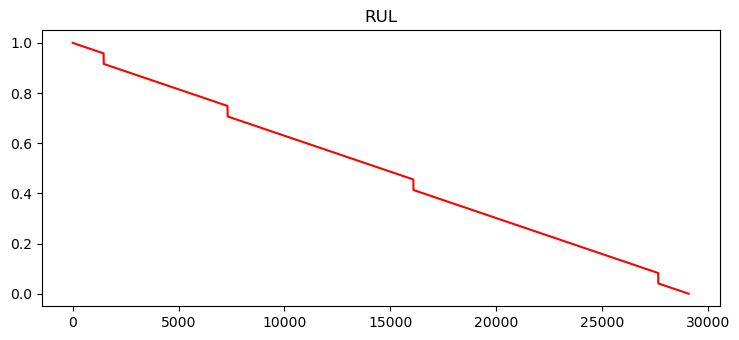

In [62]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

plt.title("Line graph")
plt.plot(range(0,len(train_data['RUL'])),train_data['RUL'], color="red")
plt.title('RUL')


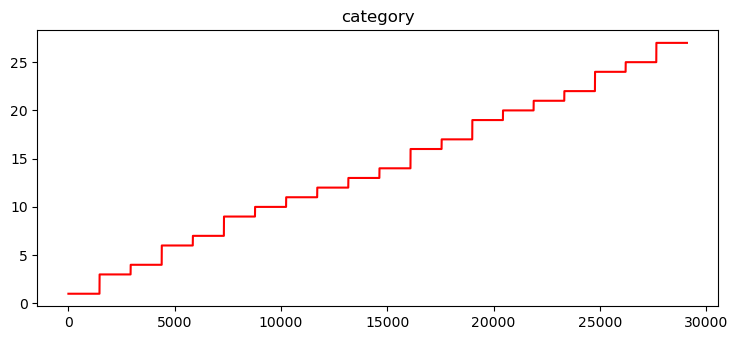

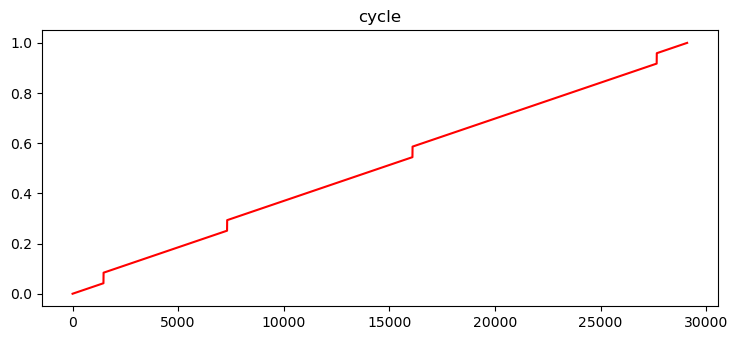

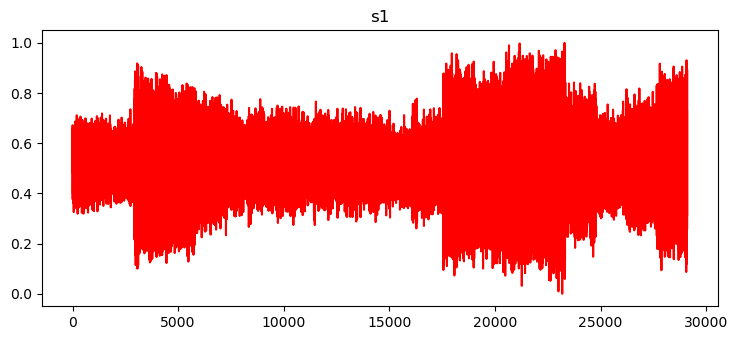

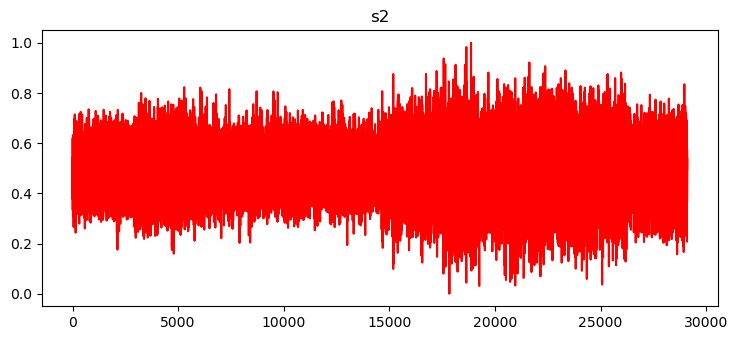

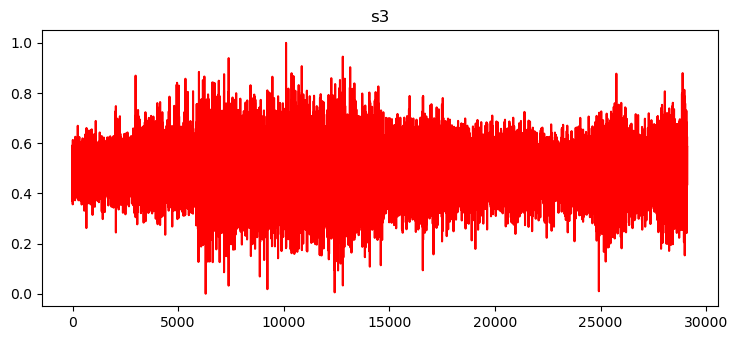

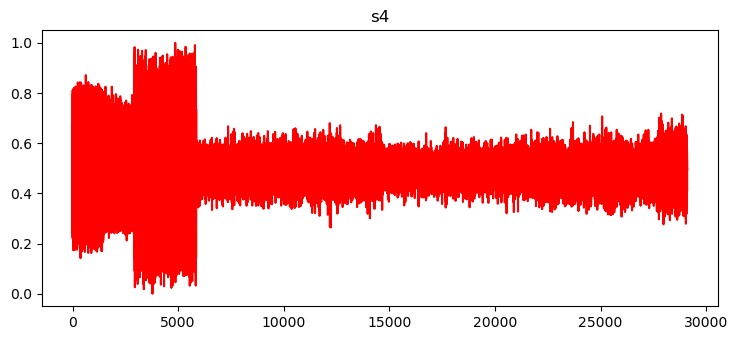

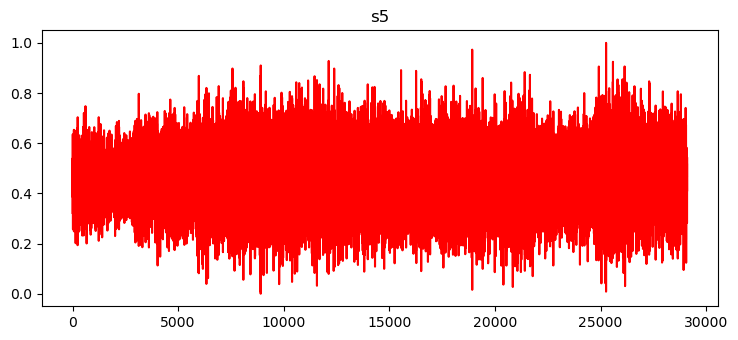

In [41]:
for i in train_data.columns[1:-1]:
    
    y=train_data[[i]].values
    


    x = range(0,len(y))

    plt.title("Line graph")
    plt.plot(x, y, color="red")
    plt.title(str(i))

    plt.show()

In [83]:
test_data.head()

,RUL,category,cycle,s1,s2,s3,s4,s5,s6
0,0.958117,2.0,0.041883,0.469170,0.499443,0.546157,0.474688,0.484226,0.501690
1,0.958089,2.0,0.041911,0.572775,0.385471,0.482286,0.226137,0.410976,0.300687
2,0.958060,2.0,0.041940,0.601086,0.360348,0.627149,0.323045,0.507235,0.498465
3,0.958032,2.0,0.041968,0.648032,0.383242,0.469450,0.627174,0.440170,0.491110
4,0.958003,2.0,0.041997,0.592633,0.576027,0.517164,0.735063,0.384482,0.480431


In [ ]:
def gen_seq(data, seq_length, columns):
    L=[]
    n = data.shape[0]
    for i in range(0, n - seq_length):
        L.append(data[i:i+seq_length][columns].values)
    return(L)


###### Homogeneity of Sequences:
For LSTM models, the sequences should be homogeneous. To accomplish this, we generate the sequences depending on the category/day variable. We split each category to into sequences, and then join them into one array in the cells below (for train and test datasets).

(data, seq_length, columns):

data = train_data[train_data['category'] == id

seq_length = 60

columns = ["s1","s2","s3","s4","s5","s6","cycle"]



In [84]:
# train_inputs = np.concatenate(np.array([gen_seq(train_data[train_data['category'] == id], 60, ["s1","s2","s3","s4","s5","s6","cycle"])
#                                for id in train_data['category'].unique()]))

train_inputs = np.concatenate(np.array([gen_seq(train_data[train_data['category'] == id], 60, ["s1","s2","s3","s4","s5","s6"])
                               for id in train_data['category'].unique()]))

train_inputs.shape


/tmp/ipykernel_341703/1987298931.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_inputs = np.concatenate(np.array([gen_seq(train_data[train_data['category'] == id], 60, ["s1","s2","s3","s4","s5","s6"])


(27900, 60, 6)

In [85]:
# train_out

# train_inputs

# for i in range(len(train_inputs)):
#     x = train_inputs[i]
#     print('%s => %s' % (x))

# test_inputs = np.concatenate(np.array([gen_seq(test_data[test_data['category'] == id], 60, ["s1","s2","s3","s4","s5","s6","cycle"])
#                                for id in test_data['category'].unique()]))

test_inputs = np.concatenate(np.array([gen_seq(test_data[test_data['category'] == id], 60, ["s1","s2","s3","s4","s5","s6"])
                               for id in test_data['category'].unique()]))

test_inputs.shape


/tmp/ipykernel_341703/940717228.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_inputs = np.concatenate(np.array([gen_seq(test_data[test_data['category'] == id], 60, ["s1","s2","s3","s4","s5","s6"])


(5592, 60, 6)

In [86]:
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements]


In [87]:

train_out = np.concatenate(np.array([gen_labels(train_data[train_data['category'] == id], 60, ["RUL"])
                               for id in train_data['category'].unique()]))

train_out.shape

/tmp/ipykernel_341703/2284794544.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_out = np.concatenate(np.array([gen_labels(train_data[train_data['category'] == id], 60, ["RUL"])


(27900, 1)

In [88]:


test_out = np.concatenate(np.array([gen_labels(test_data[test_data['category'] == id], 60, ["RUL"])
                               for id in test_data['category'].unique()]))

test_out.shape

/tmp/ipykernel_341703/418674133.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_out = np.concatenate(np.array([gen_labels(test_data[test_data['category'] == id], 60, ["RUL"])


(5592, 1)

In [97]:
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
print(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
def scheduler(epoch, lr):
      if epoch < 40:
        lr=0.00001
        return lr
      else:
        lr=0.0001
        return lr #* tf.math.exp(-0.1)
lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

es=EarlyStopping(
    monitor="val_loss",

    patience=10,
    verbose=1,
    mode="auto",
    min_delta=0.0001
)

filepath=path+'/checkpoint/RULDECLSTM/'+"weights-improvement-{epoch:02d}-{val_mae:.2f}.h5"

# fname = os.path.sep.join([filepath,args["weights"],"weights-{epoch:03d}-{val_loss:.4f}.h5"])

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath,
    monitor='val_mae',

    mode='min',
    save_best_only=True, verbose=1)


# # checkpoint_filepath = "./tmp/checkpoint"

#scaler = MinMaxScaler()



%load_ext tensorboard
%reload_ext tensorboard




# # Testing



# out_seq = np.array(y_test)#out_seq.reshape((len(out_seq), 1))
# # horizontally stack columns
# dataset = np.array(X_test)#hstack((in_seq1, in_seq2))

# pd.DataFrame(dataset)




# # shift the target sample by one step
# out_seq = np.insert(out_seq, 0, 0)
# #pre

# out_seq = np.delete(out_seq, -1)
# # define generator
# n_input = SEQUENCE_LENGHT #leght of the sequence timesteps
# testing_generator = TimeseriesGenerator(dataset, out_seq, length=n_input, batch_size=STEPS_PER_BATCH)
# # print each sample
# # for i in range(len(testing_generator)):
# #     x, y = generator[i]
# #     print('%s => %s' % (x, y))











tf.keras.backend.clear_session()

nb_features = train_inputs.shape[2]
sequence_length  = train_inputs.shape[1]
nb_out = train_out.shape[1]

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, input_shape = (sequence_length, nb_features), return_sequences = True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(nb_out, activation = 'relu')
])

lr = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 10**-7 * 10**(epoch/3))

model.compile(loss=tf.keras.losses.Huber(), optimizer = tf.keras.optimizers.Adam(lr = 10**-7), metrics =['mse','mae'])

# # self.model
# model = Sequential()

# # hidden layers
# model.add(Dense(40, activation="relu", input_dim=X_train.shape[1],kernel_regularizer=L1L2(l2=0.01,l1=0.01))) #Better
# #GOOD 60

# model.add(Dropout(0.3))


# model.add(Dense(20, activation="relu",kernel_regularizer=L2(l2=0.001)))  #Better
# #GOOD 40
# model.add(Dropout(0.5))

# model.add(Dense(20, activation="linear"))

# # output layer
# model.add(Dense(1, activation="linear"))
# softmax for probability, #values are sigmoid


# Compile the network :
# NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
# NN_model.summary()

# Configure the model and start training
model.compile(loss='huber', optimizer='adam', metrics=['mae'])

model.summary()

# y_train
#50 and 30 -->
# R^2: 0.23383518186689745
# Mean Absolute Error (MAE): 396547.5620496487
# Mean Squared Error (MSE): 306771152615.1718
# Mean Absolute Percentage Error (MAPE): 3.5912102242185946e+17
# Root Mean Squared Error (RMSE): 553869.2558855129
# Explained Variance Score: 0.30378274542758565
# Max Error: 17869119.0
# Mean Squared Log Error: 2.760667782700153
# Median Absolute Error: 279682.8125






logs/fit/20230601-130857
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


2023-06-01 13:08:57.234611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-01 13:08:57.240234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-01 13:08:57.241397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 64)            18176     
                                                                 
 dropout (Dropout)           (None, 60, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30,625
Trainable params: 30,625
Non-trainable params: 0
_________________________________________________________________


In [98]:
#FAST AI SEE IF TRIANING IMPROVES !
# 1420492
# history = model.fit(train_inputs, train_out, epochs = 20, callbacks = [lr])
history=model.fit(train_inputs,train_out,epochs=30,validation_data= (test_inputs,test_out) ,verbose=1,callbacks=[tensorboard_callback,lr,model_checkpoint_callback,es],)


Epoch 1/30


2023-06-01 13:09:02.480312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-01 13:09:02.481865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-01 13:09:02.483092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

870/872 [============================>.] - ETA: 0s - loss: 0.1579 - mae: 0.4875

2023-06-01 13:09:11.964784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-01 13:09:11.966265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-01 13:09:11.967375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 1: val_mae improved from inf to 0.54123, saving model to /home/jose/FL_AM_Defect-Detection/checkpoint/RULDECLSTM/weights-improvement-01-0.54.h5
872/872 [==============================] - 11s 9ms/step - loss: 0.1578 - mae: 0.4875 - val_loss: 0.2004 - val_mae: 0.5412 - lr: 1.0000e-07
Epoch 2/30
867/872 [============================>.] - ETA: 0s - loss: 0.1570 - mae: 0.4856
Epoch 2: val_mae did not improve from 0.54123
872/872 [==============================] - 6s 7ms/step - loss: 0.1570 - mae: 0.4856 - val_loss: 0.2004 - val_mae: 0.5412 - lr: 2.1544e-07
Epoch 3/30
865/872 [============================>.] - ETA: 0s - loss: 0.1526 - mae: 0.4766
Epoch 3: val_mae improved from 0.54123 to 0.54115, saving model to /home/jose/FL_AM_Defect-Detection/checkpoint/RULDECLSTM/weights-improvement-03-0.54.h5
872/872 [==============================] - 6s 7ms/step - loss: 0.1525 - mae: 0.4764 - val_loss: 0.2004 - val_mae: 0.5411 - lr: 4.6416e-07
Epoch 4/30
871/872 [============================>.] 

In [102]:
### Saving model

model.summary()

# model.save(path+'MLP_REG_RUL_16',save_format='h5')



# loading the saved modelweights-improvement-87-0.16.h
loaded_model = tf.keras.models.load_model('/home/jose/FL_AM_Defect-Detection/checkpoint/RULDECLSTM/weights-improvement-16-0.08.h5')



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 64)            18176     
                                                                 
 dropout (Dropout)           (None, 60, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30,625
Trainable params: 30,625
Non-trainable params: 0
_________________________________________________________________


2023-06-01 13:12:13.120451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-01 13:12:13.122616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-01 13:12:13.123690: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [103]:
_test_inputs=test_inputs[0:]
_test_out=test_out[0:]



y_pred = loaded_model.predict(_test_inputs) ## using the untinted dataset!
    
print('R^2:', metrics.r2_score(_test_out, y_pred))
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(_test_out, y_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(_test_out, y_pred))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(_test_out, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(_test_out, y_pred))) # np.sqrt

print('Explained Variance Score:', metrics.explained_variance_score(_test_out, y_pred))
print('Max Error:', metrics.max_error(_test_out, y_pred))
print('Mean Squared Log Error:', metrics.mean_squared_log_error(_test_out, y_pred))
print('Median Absolute Error:', metrics.median_absolute_error(_test_out, y_pred))

## with n_estimators = 150

# R^2: 0.9991654290573937
# Mean Absolute Error (MAE): 1158.6216816072117
# Mean Squared Error (MSE): 333818221.94037396
# Root Mean Squared Error (RMSE): 18270.692979205083
# Explained Variance Score: 0.9991654316522736
# Max Error: 1998236.0866666667
# Mean Squared Log Error: 0.012717975468372306
# Median Absolute Error: 147.4266666667536

## n_estimators = 10
# R^2: 0.9990822069686238
# Mean Absolute Error (MAE): 1213.5715068447246
# Mean Squared Error (MSE): 367106044.79767376
# Mean Absolute Percentage Error (MAPE): 1.0690696275079867e+17
# Root Mean Squared Error (RMSE): 19160.011607451437
# Explained Variance Score: 0.9990822141398445
# Max Error: 1998818.5
# Mean Squared Log Error: 0.012296657672986336
# Median Absolute Error: 137.60000000009313


2023-06-01 13:12:14.297030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-01 13:12:14.298515: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-01 13:12:14.299597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

175/175 [==============================] - 1s 3ms/step
R^2: 0.9122389967444604
Mean Absolute Error (MAE): 0.08014411947907403
Mean Squared Error (MSE): 0.009466243663007943
Mean Absolute Percentage Error (MAPE): 0.5096658311603095
Root Mean Squared Error (RMSE): 0.09729462299124214
Explained Variance Score: 0.9162248820313804
Max Error: 0.35256587939942063
Mean Squared Log Error: 0.004816542903573396
Median Absolute Error: 0.06776273983800063


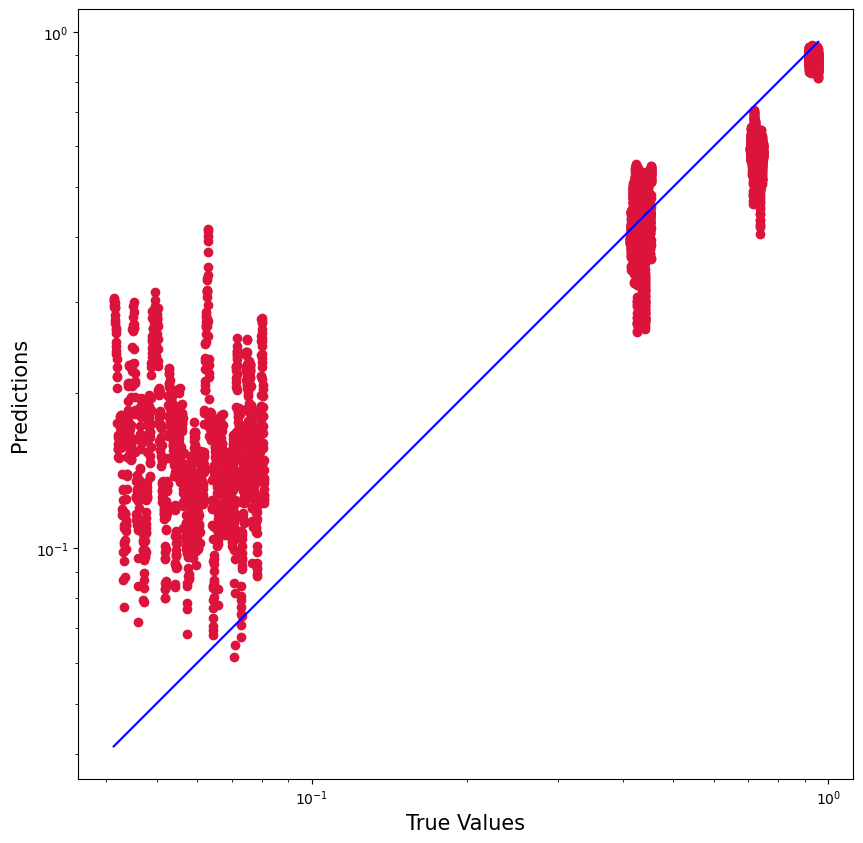

In [104]:

plt.figure(figsize=(10,10))
plt.scatter(_test_out, y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_pred), max(_test_out))
p2 = min(min(y_pred), min(_test_out))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()